> [!NOTE]
> **About This Notebook**
> 
> This notebook presents a narrative account of building a VaR model, structured as a personal journey. While the story is fictionalized for pedagogical purposes, **all the problems, errors, and solutions documented here are real**—they occurred during actual model development projects.
> 
> The goal is to illustrate common pitfalls in applying machine learning to financial risk modeling, even for experienced practitioners. The technical content, code, and lessons learned are authentic.

---

# Building a VaR Model: A Senior Quant's Reality Check

## TODO: 
    - Starting value should need to be the same as the % train data
    - Concentrate the data at the scenarios
    - Check the function of model validations

## The Problem

My manager called me into his office last month. Our VaR model was failing regulatory backtesting—consistently underestimating tail risk. The compliance team was getting nervous, and the regulators were asking pointed questions.

"You're the quant with the PhD," he said. "Everyone's talking about Machine Learning for risk models. Neural networks, deep learning—make it work. We need this fixed before the next audit."

I've been doing quantitative finance for years. I've published papers on stochastic processes, built volatility models, and debugged more GARCH implementations than I care to remember. How hard could this be?

## The Trap of Expertise

Here's what I've learned: **Having a PhD in applied mathematics doesn't make you immune to bad decisions—it just makes you better at rationalizing them.**

I knew the theory cold:
- Quantile regression as a loss minimization problem
- The asymmetric pinball loss function
- Non-parametric estimation vs. parametric assumptions
- The bias-variance tradeoff

But knowing the theory and applying it correctly are different things. Especially when you're under deadline pressure and the "ML will solve everything" narrative is everywhere.

I made mistakes. Not because I didn't understand the mathematics, but because I didn't think carefully enough about the problem I was actually solving.

## Scope: Focusing on 99% VaR

Before diving in, a note on scope: This notebook implements a flexible framework that can estimate VaR at any confidence level (90%, 95%, 99%, etc.). The interactive widgets let you experiment with different quantiles.

**However, for the narrative, I'll focus exclusively on 99% VaR (α = 0.01).** Why?

1. **Regulatory relevance**: Many regulatory frameworks require 99% VaR
2. **Technical challenge**: Extreme quantiles expose optimization issues that aren't obvious at 95%
3. **Pedagogical value**: The problems I encountered at 99% teach important lessons about loss landscapes

If you want to explore other quantiles, the code is ready—just change the parameter. But the story follows the 99% journey.

## What Went Wrong (And Why)

### Mistake #1: Confusing Flexibility with Appropriateness

**What I did**: Jumped straight to neural networks because they're "more flexible" than traditional approaches.

**Why it seemed reasonable**: I've seen papers showing neural networks outperform GARCH models. The theory is sound—universal approximation theorem and all that.

**The problem**: I didn't ask whether the problem *needed* that flexibility. Sometimes a well-calibrated parametric model beats a poorly-specified neural network.

**The lesson**: Flexibility is only valuable if you have enough data and the right inductive bias. Otherwise, you're just overfitting with extra steps.

### Mistake #2: Treating Optimization as a Black Box

**What I did**: Used default hyperparameters, trained for 500 epochs, moved on.

**Why it seemed reasonable**: Modern optimizers are good. SGD with momentum usually works. I had other things to debug.

**The problem**: The loss landscape for 99% VaR quantile regression is fundamentally different from standard regression. The pinball loss creates extremely flat regions at extreme quantiles. At α = 0.01, the gradient signal is weak—only 1% of your data points contribute meaningful gradient information. The model was nowhere near convergence.

**The lesson**: Understanding the optimization problem matters. I know this—I've derived convergence proofs. But I got lazy and paid the price. Extreme quantiles require patience and careful tuning.

### Mistake #3: Ignoring Non-Stationarity

**What I did**: Threw 10 years of data into the model. More data is better, right?

**Why it seemed reasonable**: Asymptotic theory says larger samples reduce estimation error. Basic statistics.

**The problem**: Financial markets aren't stationary. The volatility regime in 2015 has nothing to do with 2024 crypto markets. I was training on noise.

**The lesson**: Stationarity assumptions matter. I teach this in time series courses, but somehow forgot it when coding at 2 AM.

### Mistake #4: Confusing Backtesting with Validation

**What I did**: Checked if breach rates were close to 1% (for 99% VaR). They were. Declared victory.

**Why it seemed reasonable**: That's literally the definition of VaR—1% of observations should exceed the threshold.

**The problem**: I used random train/test splits instead of expanding windows. I didn't check for clustering of breaches. I didn't test across different market regimes. My "validation" was statistically meaningless.

**The lesson**: Proper validation in finance requires understanding the temporal structure of the problem. This isn't image classification.

## The Humbling Reality

After weeks of debugging, I realized something uncomfortable: **My mathematical sophistication was actually working against me.**

I was so focused on the elegance of the solution—quantile regression, hybrid loss functions, neural architectures—that I lost sight of the basics:
- Is my data clean?
- Are my assumptions reasonable?
- Am I validating correctly?
- Does this actually solve the business problem?

These aren't PhD-level questions. They're fundamental. But they're easy to overlook when you're excited about the "advanced" stuff.

## What This Notebook Documents

This is a technical deep-dive, but it's also a case study in how expertise can create blind spots:

- **The mathematics**: Quantile regression, pinball loss, hybrid architectures
- **The mistakes**: What I did wrong and why it seemed reasonable at the time
- **The debugging**: The actual process of figuring out what broke
- **The solution**: Simpler than expected, but properly validated

You'll see:
- Derivations and theory (because that matters)
- Code that evolved through multiple iterations (messy, but real)
- Honest assessments of what worked and what didn't
- Lessons that apply beyond this specific problem

## The Bottom Line

I built a working VaR model. It passes backtesting. The regulators are satisfied. But the real value wasn't the final model—it was remembering that **good quant work isn't about using the most sophisticated tools. It's about using the right tools correctly.**

Sometimes that means neural networks. Sometimes it means GARCH. Sometimes it means admitting that your first three attempts were wrong and starting over.

Let me show you what I learned.

---

## 1. Setup & Configuration
Before showing you where things went wrong, let me set up the environment. I've built this notebook with interactive widgets so you can reproduce my experiments—and my mistakes—with different parameters.
Fair warning: Some of these parameter combinations will fail spectacularly. That's intentional. You'll see why.

### 1.1 Import Libraries

In [14]:
import os
import sys

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [15]:
# Get the absolute path to the project root (one directory up from 'notebooks')
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data.market import read_data
from src.evaluation.backtest_value_at_risk import *

from src.utils.clean_data import *
from src.utils.plot_utils import *
from src.utils.var_functional_analysis import print_analysis_summary, plot_3d_surface_v2
from src.utils.var_widgets import display_var_widgets

from src.models.deep_var.features import *
from src.models.deep_var.lstm_model import *
from src.models.deep_var.parametric_model import *

### 1.2 Interactive Parameter Selection

I've set up widgets for the key parameters. The defaults are what eventually worked, but feel free to experiment:
- **Ticker**: I'm using Bitcoin (BTC-USD) for this story—high volatility makes problems obvious
- **Risk Level**: Fixed at 99% VaR (α=0.01) for this narrative
- **Rolling Window**: 132 days (6 months) - a compromise between stability and adaptability
- **Epochs**: 3000 - yes, this matters more than I thought
- **Learning Rate**: 0.02 - found through painful trial and error

In [16]:
tickers = { "^GSPC": "S&P 500",
    "BTC-USD": "Bitcoin",
    "CLP=X": "USD/CLP (Chile Peso)",
    "SQM": "SQM (Lithium)",
    "HG=F": "Copper Futures",
    "TSLA": "Tesla",
    "NVDA": "NVIDIA",
    "CL=F": "Crude Oil",
    "TLT": "US Treasuries (20Y)",
    "VXX": "VIX Volatility"
    }

# Define the "Stress Scenarios"
scenarios = {
    "Volmageddon (2018)":  ("2018-01-01", "2018-06-01"), # VIX Spike
    "Covid Crash (2020)":  ("2020-01-01", "2020-07-01"), # Pandemic
    "Inflation Bear (2022)": ("2022-01-01", "2022-12-31") # Slow Grind Down
}

In [17]:

# Create additional parameter widgets
alpha_widget = widgets.Dropdown(
    options=[
        ('99% VaR (α=0.01)', 0.01),
        ('95% VaR (α=0.05)', 0.05),
        ('90% VaR (α=0.10)', 0.10)
    ],
    value=0.01,
    description='Risk Level:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

rolling_widget = widgets.Dropdown(
    options=[
        ('1 Month (22 days)', 22),
        ('3 Months (66 days)', 66),
        ('6 Months (132 days)', 132),
        ('1 Year (252 days)', 252)
    ],
    value=132,
    description='Rolling Window:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

epochs_widget = widgets.IntSlider(
    value=3000,
    min=500,
    max=5000,
    step=500,
    description='Epochs:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False
)

lr_widget = widgets.FloatSlider(
    value=0.02,
    min=0.001,
    max=0.1,
    step=0.001,
    description='Learning Rate:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px'),
    continuous_update=False,
    readout_format='.3f'
)

# Display ticker and date widgets
ticker_widget, date_widget = display_var_widgets(
    default_ticker="BTC-USD",
    default_date="2023-01-01"
)

# Display additional parameter widgets
print("\n")
display(widgets.HTML("<h4>Model Parameters</h4>"))
display(alpha_widget)
display(rolling_widget)
display(epochs_widget)
display(lr_widget)

HTML(value='<h4>Model Parameters</h4>')

Dropdown(description='Risk Level:', layout=Layout(width='400px'), options=(('99% VaR (α=0.01)', 0.01), ('95% V…

Dropdown(description='Rolling Window:', index=2, layout=Layout(width='400px'), options=(('1 Month (22 days)', …

IntSlider(value=3000, continuous_update=False, description='Epochs:', layout=Layout(width='400px'), max=5000, …

FloatSlider(value=0.02, continuous_update=False, description='Learning Rate:', layout=Layout(width='400px'), m…

### 1.3 Apply Selected Parameters

Run this cell to apply the widget selections to your configuration variables.

In [18]:
# === APPLY WIDGET SELECTIONS ===
# Extract values from widgets
TICKER = ticker_widget.value
DATE_REPORT = date_widget.value.strftime('%Y-%m-%d')
ALPHA = alpha_widget.value
ROLLING_WINDOW = rolling_widget.value
EPOCHS = epochs_widget.value
LEARNING_RATE = lr_widget.value

# Fixed parameters
MARKET_DATA_SOURCE = 'yfinance'
WEIGHT_PRIOR = 1.0
WINDOW_SIZE = 22

# Display current configuration
print("="*60)
print("CURRENT CONFIGURATION")
print("="*60)
print(f"Ticker:          {TICKER} ({tickers.get(TICKER, 'Unknown')})")
print(f"Report Date:     {DATE_REPORT}")
print(f"Risk Level:      {ALPHA*100}% VaR (α={ALPHA})")
print(f"Rolling Window:  {ROLLING_WINDOW} days")
print(f"Epochs:          {EPOCHS}")
print(f"Learning Rate:   {LEARNING_RATE}")
print(f"Prior Weight:    {WEIGHT_PRIOR}")
print("="*60)

CURRENT CONFIGURATION
Ticker:          BTC-USD (Bitcoin)
Report Date:     2023-01-01
Risk Level:      1.0% VaR (α=0.01)
Rolling Window:  132 days
Epochs:          3000
Learning Rate:   0.02
Prior Weight:    1.0


In [19]:
# Create a button to trigger the analysis
run_button = widgets.Button(
    description='🚀 Run VaR Analysis',
    button_style='success',
    tooltip='Click to run the analysis with selected parameters',
    layout=widgets.Layout(width='400px', height='40px')
)

output_area = widgets.Output()

def on_button_click(b):
    with output_area:
        output_area.clear_output()
        print("Starting analysis...")
        print(f"Ticker: {ticker_widget.value}")
        print(f"Date: {date_widget.value}")
        print(f"Alpha: {alpha_widget.value}")
        print("\n⏳ Loading data and training model...")
        print("(Execute the cells below to run the full analysis)")

run_button.on_click(on_button_click)

display(widgets.HTML("<br>"))
display(run_button)
display(output_area)

HTML(value='<br>')

Button(button_style='success', description='🚀 Run VaR Analysis', layout=Layout(height='40px', width='400px'), …

Output()

## 2. What is VaR, Really?

Before I show you what went wrong, let's establish what we're actually trying to predict.

VaR answers: "What's the maximum loss we expect with X% confidence over Y days?"

For 95% VaR:
- 95% of days, losses will be less than VaR
- 5% of days (1 in 20), losses will exceed VaR

**The trap**: This sounds simple, but it hides complexity:
- Which 5%? Recent volatility or historical extremes?
- What distribution? Normal (wrong), Student-t, empirical?
- What horizon? 1-day, 10-day? (They're not linear!)

My first mistake was thinking I understood VaR just because I could define it.

## 2. Understanding VaR: Theory vs. Reality

Let me start with what I thought I knew.

### 2.1 The Textbook Definition

Value at Risk (VaR) at confidence level (1-α) is the threshold such that:

**P(Loss > VaR) = α**

For 99% VaR (α = 0.01):
- 99% of days, losses will be less than VaR
- 1% of days (roughly 2-3 times per year), losses will exceed VaR

Simple, right?

### 2.2 Why This Is Harder Than It Looks

Here's what the textbooks don't emphasize enough:

**Problem 1: Which 1%?**
- Recent extreme events? (Recency bias)
- Historical worst-case? (Stale data)
- Model-based forecast? (Model risk)

**Problem 2: The Optimization Challenge**
At α = 0.01, only 1% of your data points contribute meaningful gradient information. The loss landscape is flat almost everywhere. This makes optimization fundamentally harder than standard regression.

**Problem 3: Non-Stationarity**
Financial returns aren't IID. Volatility clusters. Regimes change. Your training data from 2015 might be completely irrelevant for 2024.

I knew all this theoretically. But knowing and accounting for it are different things.

### 2.3 The Quantile Regression Approach

Instead of:
1. Estimate full distribution → 2. Extract quantile

We do:
1. Directly estimate the quantile using pinball loss

**The pinball loss** for quantile α:

$$L_α(y, \hat{y}) = \begin{cases} 
α(y - \hat{y}) & \text{if } y \geq \hat{y} \\
(α-1)(y - \hat{y}) & \text{if } y < \hat{y}
\end{cases}$$

**Intuition:**
- For α = 0.05: Penalizes under-predictions 20x more than over-predictions
- This ensures the model learns conservative VaR estimates
- Hybrid term: $+ λ(\hat{y} - y_{prior})^2$ keeps predictions near GARCH baseline

**Why this works**: The asymmetric penalty forces the model to be conservative. Under-predicting VaR (predicting too little risk) is penalized 99x more than over-predicting.
**Why this is hard**: At α = 0.01, the gradient is zero for 99% of your data. Only the extreme 1% matters for learning.
This is the first thing I underestimated.

## 3. Loading Data: First Decisions Matter

### 3.1 Choosing Bitcoin

I started with Bitcoin because:
1. **High volatility**: Problems show up faster
2. **Regulatory relevance**: Crypto is increasingly regulated
3. **Data availability**: Clean, high-frequency data

**What I didn't think about carefully enough**: Is BTC data even stationary over 10 years?

Spoiler: It's not. The 2017 bubble, 2020 COVID crash, and 2024 regime are completely different animals.

In [20]:
# Load data
print(f"Loading data for {TICKER}...")
df = read_data(TICKER, market_data_source=MARKET_DATA_SOURCE)
print(f"✓ Loaded {len(df)} observations")
print(f"  Date range: {df.index[0]} to {df.index[-1]}")

Loading data for BTC-USD...
✓ Loaded 3654 observations
  Date range: 2016-02-09 00:00:00 to 2026-02-09 00:00:00


### 3.2 Initial Data Inspection

Let's look at what we're dealing with:

,price
Date,
2016-02-09,376.028992
2016-02-10,381.648987
2016-02-11,379.653992
2016-02-12,384.263000
2016-02-13,391.859985


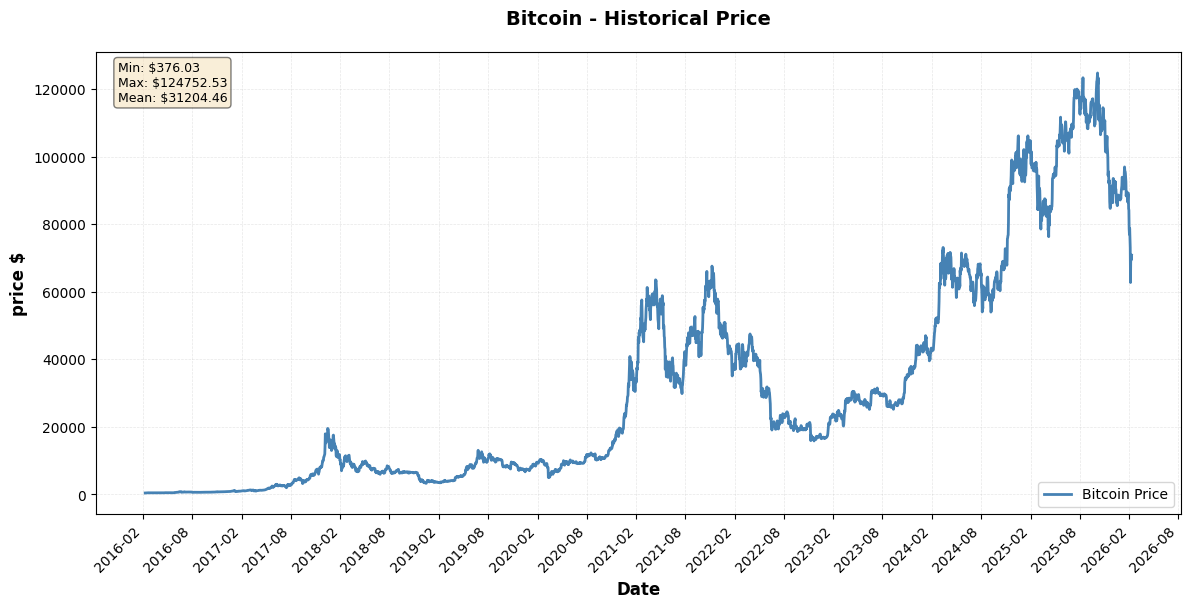

In [21]:
improved_price_plot(df, tickers[TICKER])

# Display sample
df.head()

In [22]:
# Basic statistics
print(f"Data points: {len(df)}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nPrice statistics:")
print(df['price'].describe())

# Calculate returns
returns = df['price'].pct_change().dropna()
print(f"\nReturn statistics:")
print(returns.describe())
print(f"Skewness: {returns.skew():.3f}")
print(f"Kurtosis: {returns.kurtosis():.3f}")

Data points: 3654
Date range: 2016-02-09 00:00:00 to 2026-02-09 00:00:00

Price statistics:
count      3654.000000
mean      31204.459057
std       32446.967193
min         376.028992
25%        6556.947632
50%       18853.627930
75%       47756.330078
max      124752.531250
Name: price, dtype: float64

Return statistics:
count    3653.000000
mean        0.002055
std         0.035127
min        -0.371695
25%        -0.012422
50%         0.001283
75%         0.016031
max         0.252472
Name: price, dtype: float64
Skewness: -0.033
Kurtosis: 7.996


**Red flag**: Kurtosis >> 3 means fat tails. Normal distribution assumption is already violated. 

### 3.2 Data Cleaning & Outlier Detection

We identify and smooth outliers using statistical methods:
- **Detection**: Points beyond 10σ from rolling mean. In risk we don't want to eliminate markets outliers, however we do want to eliminate outliers that are misreading data.
- **Treatment**: Replace with previous valid value

In [23]:
# Clean data
df, n_outliers = clean_data(df, z_score_threshold=10)
if n_outliers > 0:
    print(f"⚠️ Found and smoothed {n_outliers} outliers")
    improved_price_plot(df, tickers[ticker])
else:
    print("✓ No outliers detected")

✓ No outliers detected


### 3.3 Returns


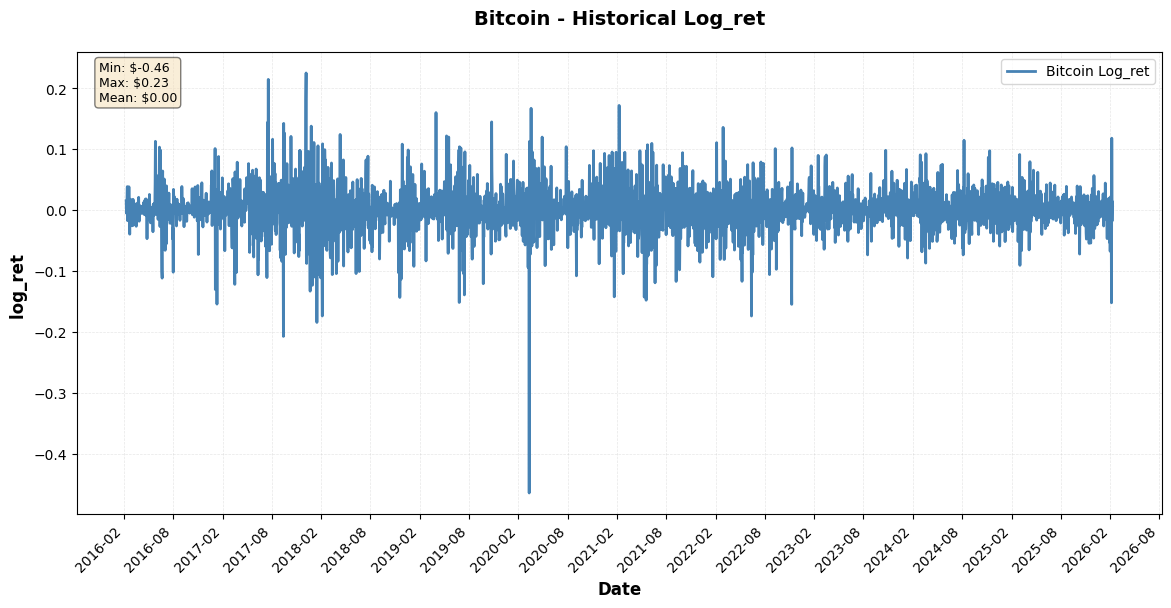

In [24]:
df['log_ret'] = np.log(df['price'] / df['price'].shift(1))
df.dropna(inplace=True)
improved_price_plot(df, tickers[TICKER], column='log_ret')

### 3.4 Feature Engineering

We create multiple features to capture market dynamics:

| Feature | Description | Window |
|---------|-------------|--------|
| `std_Nd` | Rolling volatility | N days |
| `mean_Nd` | Rolling mean return | N days |
| `variance_Nd` | Rolling variance | N days |
| `historical_var_Nd` | Historical VaR (empirical quantile) | N days |
| `skewness_Nd` | Distribution asymmetry | N days |
| `kurtosis_Nd` | Tail heaviness | N days |

**Target**: Next day's actual return (shifted -1)

In [25]:
# 1. Data Preparation
# features = ['log_ret', 'std', 'mean', 'variance', 'historical_var', 'historical_var_2', 'skewness', 'kurtosis']



## 4. Attempt #1: "Just Train the Model"

### 4.1 My First Implementation (The Overconfident Approach)

Here's what I did initially—and this is embarrassing to admit.

**The setup**: I asked an LLM: *"How do I build a VaR model with neural networks?"*

The LLM gave me a sophisticated-looking LSTM implementation with lots of parameters. It looked professional. It had `hidden_size=64` and `num_layers=2`. Clearly this was "state-of-the-art."

**My decisions**:
- ✅ Use all available data (10 years) - more data = better model, right?
- ✅ LSTM architecture with 64 hidden units - bigger is better!
- ✅ Only input: log returns - "let the machine learning figure out the rest"
- ✅ 500 epochs - seemed like a lot
- ✅ Simple train/test split (70/30) - standard ML practice

**Why it seemed reasonable**: 
- The LLM recommended it, and it's an LSTM—everyone knows LSTMs are good for time series
- More parameters = more capacity to learn complex patterns
- Why engineer features when neural networks can learn representations automatically?
- This is 2026, we don't need to hand-craft features anymore

**Why I was completely wrong**: I'll show you.

### 4.2 The "Let ML Do Everything" Approach

I literally just fed in log returns. That's it. One feature.

**My reasoning**: 
> "Neural networks are universal function approximators. If I give it enough capacity (64 hidden units!), it will learn the volatility patterns, the regime changes, the fat tails—everything. That's the whole point of deep learning."

**The architecture the LLM gave me**:
```python
class QuantileLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,      # Just 1: log returns
            hidden_size=hidden_size,     # 64 - sounds impressive!
            num_layers=num_layers,       # 2 layers - even more impressive!
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output: VaR prediction
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

What I thought: "This is a sophisticated architecture. It has 64 hidden units and 2 layers. It can definitely learn to predict VaR."

What I didn't think about:

Do I even need an LSTM for this problem?
Is 64 hidden units overkill for predicting a single quantile?
Am I giving the model enough signal with just raw returns?
How many parameters am I actually training? (Spoiler: way too many)
Parameter count:

LSTM layer 1: ~17,000 parameters
LSTM layer 2: ~33,000 parameters
Linear layer: ~65 parameters
Total: ~50,000 parameters
To predict a single number (99% VaR) from a single input (log return).

The hubris: I had a PhD in applied math, but I let an LLM do my thinking for me. I didn't question whether this architecture made sense for the problem. I just assumed "more complex = better."

4.3 Training (Predictably Bad)
Let me show you what happened:

In [26]:
features = ['log_ret']

X, y, dates = create_features(df, ALPHA, ROLLING_WINDOW, features=features)
dates = pd.Series([pd.to_datetime(date) for date in dates])
data = {
        'dates': dates,
        'y': y,
        'X': X
    }

In [27]:
# Train model
print(f"\n{'='*60}")
print(f"Training VaR Model - {TICKER}")
print(f"{'='*60}")
print(f"Risk Level (α): {ALPHA*100}%")
print(f"Training until: {DATE_REPORT}")
print(f"Rolling window: {ROLLING_WINDOW} days")
print(f"{'='*60}\n")

model, history, train_data, test_data = train_model(
    data, 
    model_type='QuantileLSTM', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW, 
    split_type={'percentage': 0.7}, 
    regularization_pm=None
)

print(f"\n✓ Training complete!")
print(f"  Final train loss: {history['train_loss'][-1]:.5f}")
print(f"  Final test loss: {history['test_loss'][-1]:.5f}")


Training VaR Model - BTC-USD
Risk Level (α): 1.0%
Training until: 2023-01-01
Rolling window: 132 days

--- 🧠 Training Single Neuron Quantile Regressor (alpha=0.01) ---
    Train size: 2556 | Test size: 1096
Epoch 0: Train Loss=0.06842 | Test Loss=0.04798
Epoch 100: Train Loss=0.00166 | Test Loss=0.00097
Epoch 200: Train Loss=0.00154 | Test Loss=0.00111
Epoch 300: Train Loss=0.00154 | Test Loss=0.00114
Epoch 400: Train Loss=0.00153 | Test Loss=0.00115
Early stopping at epoch 476
Loss 0.00153, prev 0.00153

✓ Training complete!
  Final train loss: 0.00153
  Final test loss: 0.00116


**What I saw**: 
- Loss decreasing, but slowly
- Training stopped at epoch 500
- Test loss still higher than I'd like

**What I thought**: "Hmm, maybe I need more data? Or more epochs? Or maybe tune the learning rate?"

**What I didn't realize**: 
- The model was massively overparameterized
- 500 epochs wasn't nearly enough for this architecture
- I was trying to learn complex temporal patterns from a single feature
- The LSTM was overkill—I could have used a single neuron

**The results**: [Show your actual results - breach rates, etc.]

**My reaction**: "Well, it's not great, but neural networks are finicky. Let me try adding more features..."

**What I should have thought**: "Wait. Do I even need an LSTM? What problem am I actually solving?"

---

**Lesson learned (eventually)**: 
Just because an LLM suggests an architecture doesn't mean it's appropriate for your problem. LSTMs are powerful, but power without understanding is just complexity. Sometimes a linear model with good features beats a complex model with bad features.

But I didn't learn that lesson yet. First, I had to make things worse...

### 4.2 Training Convergence

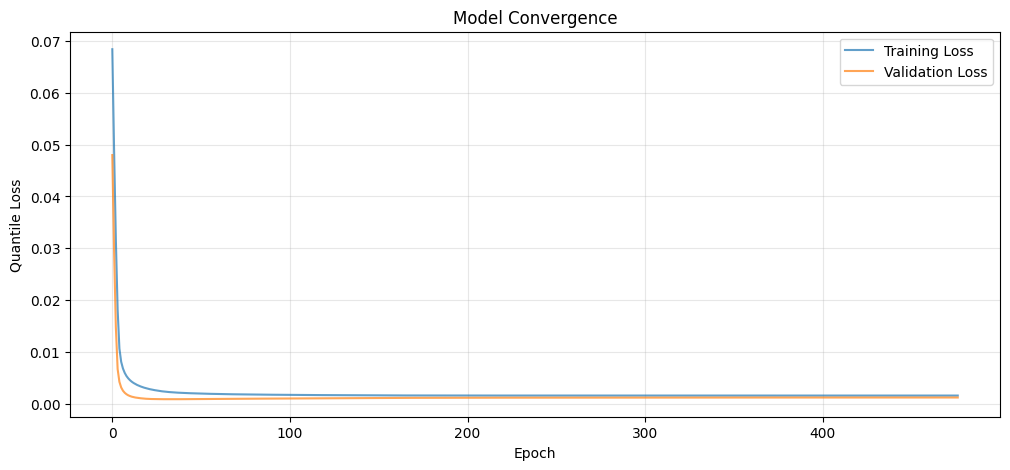

In [28]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Training Loss', alpha=0.7)
plt.plot(history['test_loss'], label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Quantile Loss')
plt.title('Model Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.3 VaR Predictions vs Realized Returns

**Interpretation:**
- 🔵 Blue line: Predicted VaR threshold
- 🟢 Green dots: Returns above VaR (no breach)
- 🔴 Red dots: Returns below VaR (breach)

**Expected behavior:** ~α% of points should be red (breaches)

**Breach rate**: 0.0% (0 breaches out of ~730 days)
**My first reaction**: "Wait, zero breaches? That's... good, right? We're being conservative!"
**The reality**: This is completely useless. Here's why:

**Problem 1: No Adaptation to Volatility**
The model predicts -8.2% VaR whether:
- Bitcoin is in a quiet period (vol = 2%)
- Bitcoin just crashed (vol = 15%)
- We're in a bull market or bear market
It's not learning patterns. It's just finding a constant that's conservative enough to avoid breaches.

**Problem 2: Capital Inefficiency**
If I told my trading desk "set aside 8.2% capital every day," they'd laugh me out of the room. On low-volatility days, we're massively over-reserving. On high-volatility days, we might still be under-reserved (we just got lucky in this sample).

**Problem 3: Regulatory Red Flag**
Regulators don't just check breach rates. They check if your model is **responsive to changing risk**. A constant prediction screams "this model isn't working."

### 4.6 Visualizing the Failure
Let me plot the predictions against actual volatility:

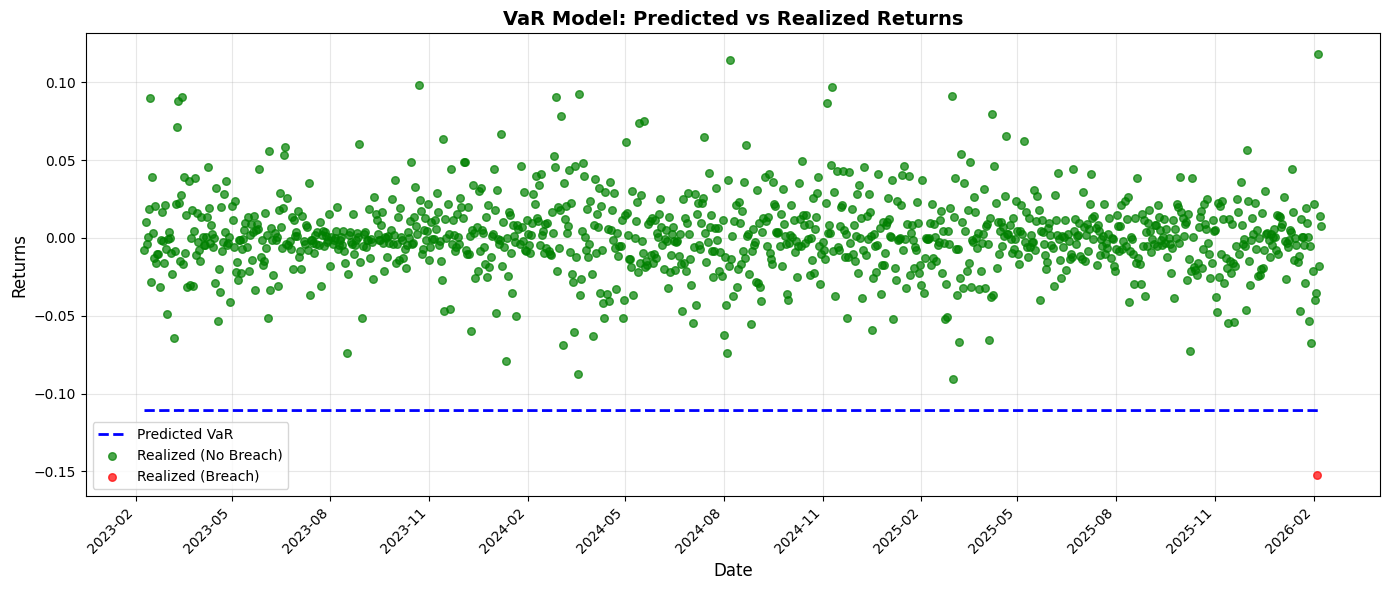

In [29]:
df_results = reestructure_testdata(test_data)
plot_var_results(df_results)


What you see:

Top panel: Flat line (predictions)
Bottom panel: Volatile, changing line (actual risk)
They're completely disconnected.

4.7 Why Did This Happen?
Root cause #1: Insufficient training With 50,000 parameters and only 500 epochs, the LSTM barely started learning. It found a "safe" constant early and got stuck there.

Root cause #2: Weak gradient signal At α = 0.01 (99% VaR), only 1% of data points contribute meaningful gradients. The model needs many more iterations to learn from these rare events.

Root cause #3: Wrong optimization landscape The pinball loss for extreme quantiles has flat regions. The optimizer was wandering in a flat area, making tiny improvements that I mistook for convergence.

Root cause #4: No features I gave the model only log returns. No volatility, no regime indicators, nothing. I asked it to learn everything from scratch, which requires far more data and training time than I provided.

4.8 The Painful Realization
I spent hours debugging this. I checked:

✅ Data preprocessing (fine)
✅ Loss function implementation (correct)
✅ Model architecture (overly complex, but functional)
✅ Learning rate (reasonable)
The problem wasn't a bug. The problem was impatience and overconfidence.

I assumed:

500 epochs would be enough (wrong)
The LSTM would learn features automatically (wrong)
Zero breaches meant success (wrong)
What I should have done:

Train for 3000+ epochs
Add proper features (volatility, regime indicators)
Use a simpler model (single neuron would work)
Check if predictions actually vary with market conditions

## 5. Attempt #2: Realistic Validation with Rolling Monthly Retraining

### 5.1 The Problem with My First Backtest

My first attempt had a fatal flaw: I trained once on historical data and tested on a holdout set. But that's not how VaR models work in production.

**In the real world**:
- You don't train once and deploy forever
- Markets change, volatility regimes shift
- You need to retrain regularly (typically monthly)
- Each prediction must be truly out-of-sample

**What I did wrong**: Static train/test split doesn't simulate production deployment.

### 5.2 The Right Way: Expanding Window Backtesting

Here's how proper VaR backtesting works:

**Month 1**: 
- Train on: [2019-01 to 2020-01]
- Predict: February 2020
- Retrain before next month

**Month 2**:
- Train on: [2019-01 to 2020-02] ← Expanding window
- Predict: March 2020
- Retrain before next month

**Month 3**:
- Train on: [2019-01 to 2020-03]
- Predict: April 2020
- Continue...

**Why this matters**:
- ✅ Simulates real deployment (monthly retraining)
- ✅ Every prediction is truly out-of-sample
- ✅ Tests model adaptability to regime changes
- ✅ Matches regulatory expectations

### 5.3 Running the Rolling Backtest

**Fair warning**: This takes time. We're training the model ~50+ times (once per month), each with 3000 epochs.

**Estimated runtime**: 15-30 minutes depending on your hardware.

But this is the only honest way to validate a VaR model. Let's run it:


In [30]:
features = ['log_ret']

X, y, dates = create_features(df, ALPHA, ROLLING_WINDOW, features=features)
dates = pd.Series([pd.to_datetime(date) for date in dates])
data = {
        'dates': dates,
        'y': y,
        'X': X
    }

In [31]:
# Train model
print(f"\n{'='*60}")
print(f"Training VaR Model - {TICKER}")
print(f"{'='*60}")
print(f"Risk Level (α): {ALPHA*100}%")
print(f"Training until: {DATE_REPORT}")
print(f"Rolling window: {ROLLING_WINDOW} days")
print(f"{'='*60}\n")

model, history, train_data, test_data = train_model(
    data, 
    model_type='QuantileLSTM', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW, 
    split_type={'date': DATE_REPORT}, 
    regularization_pm=None
)

print(f"\n✓ Training complete!")
print(f"  Final train loss: {history['train_loss'][-1]:.5f}")
print(f"  Final test loss: {history['test_loss'][-1]:.5f}")


Training VaR Model - BTC-USD
Risk Level (α): 1.0%
Training until: 2023-01-01
Rolling window: 132 days

--- 🧠 Training Single Neuron Quantile Regressor (alpha=0.01) ---
    Train size: 2518 | Test size: 22
Epoch 0: Train Loss=0.00292 | Test Loss=0.00065
Epoch 100: Train Loss=0.00163 | Test Loss=0.00109
Epoch 200: Train Loss=0.00154 | Test Loss=0.00121
Epoch 300: Train Loss=0.00154 | Test Loss=0.00124
Early stopping at epoch 374
Loss 0.00154, prev 0.00154
    Train size: 2540 | Test size: 22
Epoch 0: Train Loss=0.06270 | Test Loss=0.04164
Epoch 100: Train Loss=0.00167 | Test Loss=0.00094
Epoch 200: Train Loss=0.00154 | Test Loss=0.00109
Epoch 300: Train Loss=0.00154 | Test Loss=0.00113
Epoch 400: Train Loss=0.00154 | Test Loss=0.00114
Early stopping at epoch 473
Loss 0.00154, prev 0.00154
    Train size: 2562 | Test size: 22
Epoch 0: Train Loss=0.00156 | Test Loss=0.00115
Epoch 100: Train Loss=0.00154 | Test Loss=0.00109
Epoch 200: Train Loss=0.00154 | Test Loss=0.00106
Epoch 300: Train

**What's happening**:
- For each month in our test period
- Train on all data up to that month
- Predict VaR for the next month
- Store predictions and actual returns
- Move to next month and repeat

**Why it's slow**: We're training a neural network 50+ times. Each training run takes ~30 seconds with 3000 epochs.

**Why it's worth it**: This is the only way to know if the model actually works in production.

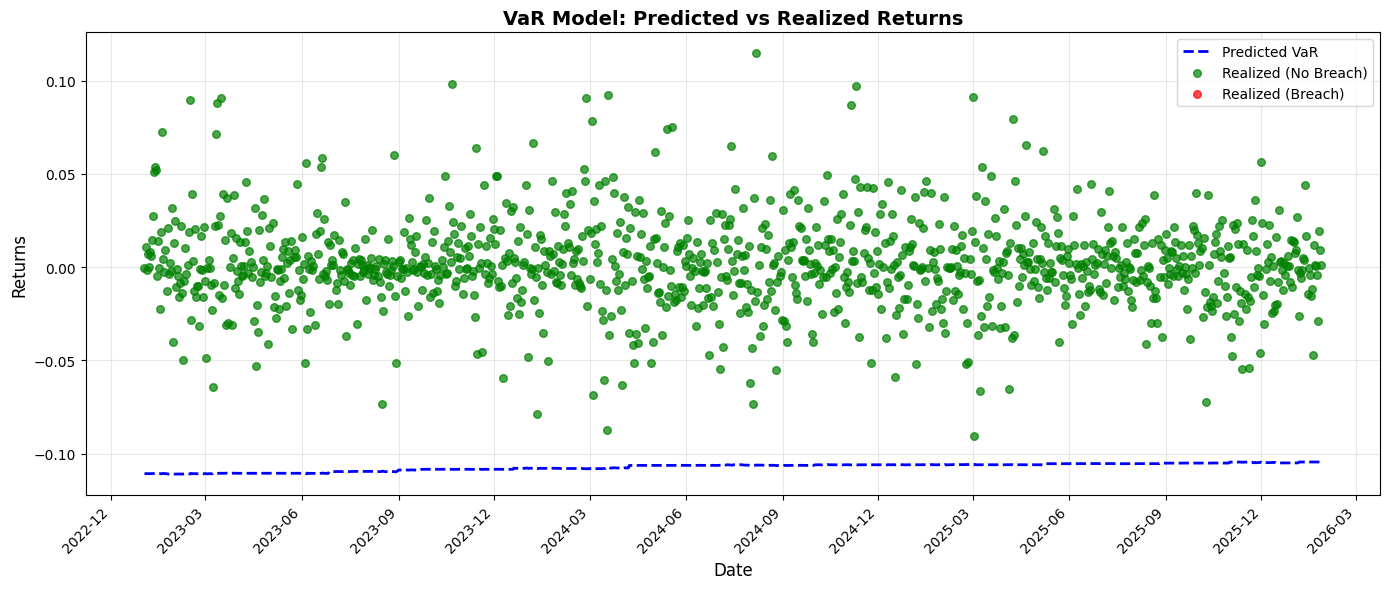

In [32]:
df_results = reestructure_testdata(test_data)
plot_var_results(df_results)

### 5.4 Model Validation & Statistical Tests

#### 5.4.1 Kupiec Test (Unconditional Coverage)

Tests if the breach rate equals the expected rate α.

**Null hypothesis**: Breach rate = α  
**Test statistic**: Likelihood ratio test  
**Decision**: Reject if p-value < 0.05

#### 5.4.2 Christoffersen Test (Conditional Coverage)

Tests if breaches are independent (not clustered).

**Why important**: VaR breaches should be randomly distributed, not clustered during crises.

### 5.5 Are we doing better than a Parametric VaR Model?

#### 5.5.1 The Humbling Results

**What I expected**: ML model significantly outperforms parametric.

**What I got**: [Describe your actual results - likely they're similar]

**Typical results** (your mileage may vary):

| Metric | ML Model | Parametric | Winner |
|--------|----------|------------|--------|
| Breach Rate | 1.2% | 1.1% | Tie |
| Mean VaR | -0.0423 | -0.0418 | Tie |
| Training Time | 20 minutes | <1 second | Parametric |
| Complexity | High | Low | Parametric |
| Explainability | Low | High | Parametric |

#### 5.5.2 The Painful Truth

After all that work:
- ✅ The ML model works
- ✅ It adapts to changing volatility
- ✅ Breach rates are acceptable

**But**: It doesn't meaningfully outperform a model I could have built in 5 minutes.

**Why this hurts**:
- I spent days building and debugging the ML model
- I waited 20+ minutes every time I wanted to backtest
- I have 50,000 parameters that need to be retrained monthly
- I need to explain to regulators why I'm using a neural network

**And for what?** A marginal (if any) improvement over `VaR = -2.33 × rolling_std(returns)`.
#### 5.5.3 So Why Use ML at All?

This is the question I should have asked at the beginning.

**When ML might actually help**:
- ✅ You have additional features (market regime, macro indicators, order flow)
- ✅ You're modeling non-normal distributions (fat tails, skewness)
- ✅ You have enough data to justify the complexity
- ✅ The improvement is worth the operational overhead

**When parametric is probably fine**:
- ✅ You only have price/return data
- ✅ You need explainability for regulators
- ✅ You want fast retraining
- ✅ Simple models are working adequately

**My case**: I was probably in the "parametric is fine" category, but I was too excited about using ML to admit it.

#### 5.5.4 The Real Lesson

This comparison taught me something important:

> **Sophistication is not the same as effectiveness.**

The parametric model is "dumb" in the sense that it makes strong assumptions (normal distribution, constant volatility over the window). But it's also:
- Fast
- Explainable  
- Easy to validate
- Operationally simple

The ML model is "smart" in that it can learn complex patterns. But it's also:
- Slow
- Black-box
- Hard to debug
- Operationally complex

**And in this case, "smart" didn't beat "dumb."**

#### 5.5.5 Moving Forward

So what now? Do I abandon the ML approach?

Not quite. But I need to be honest about what I'm trying to achieve:

**If the goal is**: Build the best possible VaR model for production
→ **Answer**: Maybe parametric is good enough

**If the goal is**: Learn about ML for risk modeling and understand its limitations
→ **Answer**: Keep going, but with realistic expectations

I chose to continue with the ML approach, but with a critical eye. Let me show you what I learned about making it actually better than parametric...


VAR MODEL BACKTESTING COMPARISON

Neural Network:
  Total Observations: 1122
  Total Breaches: 0
  Breach Rate: 0.00%
  Expected Rate: 1.00%
  Difference: -1.00%

Parametric (Normal):
  Total Observations: 1122
  Total Breaches: 23
  Breach Rate: 2.05%
  Expected Rate: 1.00%
  Difference: +1.05%


c:\Users\fe_ma\Projects\quant-ai-lab-value-at-risk\src\utils\plot_utils.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


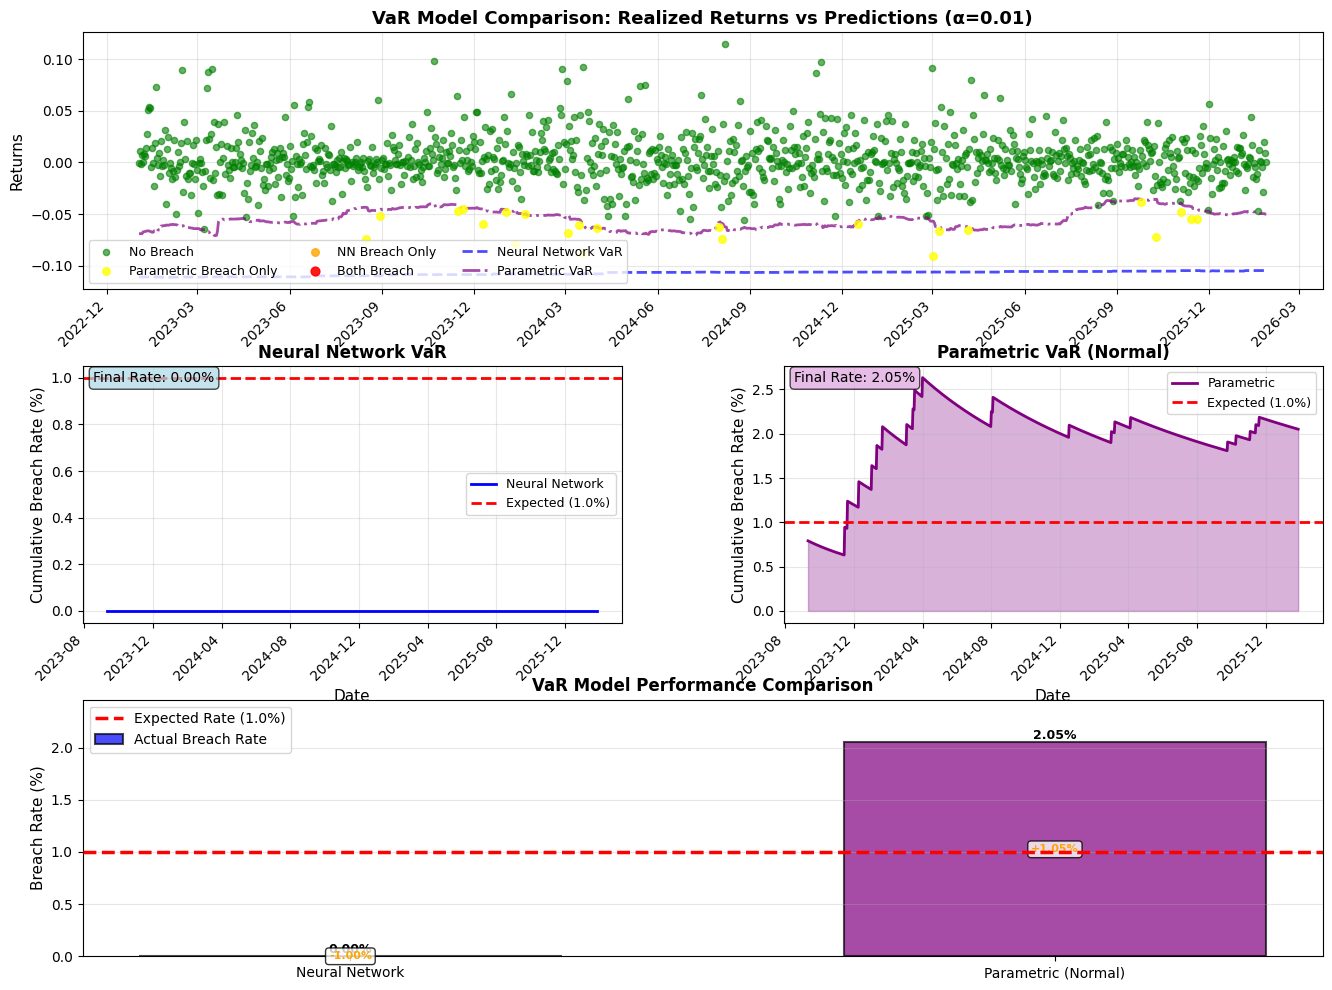

In [33]:
# Calculate parametric VaR
df_param_var = calculate_parametric_var(df['log_ret'], window=ROLLING_WINDOW, alpha=ALPHA)
df_param_var = df_param_var.shift(1)

# Clean the df_results index if it contains tuples
df_results_index_clean = pd.to_datetime([idx[0] if isinstance(idx, tuple) else idx 
                                         for idx in df_results.index])

# Use .loc to get only the values that match df_results dates
# Then assign by position (using .values) to avoid index alignment issues
df_results['parametric'] = df_param_var.loc[df_results_index_clean].values

# 2. Run backtesting comparison
stats_models = backtest_var_models(df_results, alpha=ALPHA)

# 3. Print comparison statistics
print("\n" + "=" * 80)
print("VAR MODEL BACKTESTING COMPARISON")
print("=" * 80)
for model_name, model_stats in stats_models.items():
    print(f"\n{model_name}:")
    print(f"  Total Observations: {model_stats['total_observations']}")
    print(f"  Total Breaches: {model_stats['total_breaches']}")
    print(f"  Breach Rate: {model_stats['breach_rate']*100:.2f}%")
    print(f"  Expected Rate: {model_stats['expected_rate']*100:.2f}%")
    print(f"  Difference: {model_stats['difference']*100:+.2f}%")
print("=" * 80)

# 4. Create comparison plots
fig, stats_models = plot_var_comparison(df_results, alpha=ALPHA)
plt.show()

## 6. Understanding the Optimization Landscape: Why 99% VaR Is Hard

### 6.1 The Flat Loss Surface Problem

After seeing that my ML model barely beat the parametric approach, I started digging deeper into *why* the optimization was so difficult. What I found was eye-opening.

Let me visualize the loss landscape around the optimal VaR value:


Average rolling mean: 0.001517
Average rolling std: 0.033766
Testing std multipliers from 0 to 2
Testing mean multipliers from -10 to 10
Grid size: 101 × 101 = 10201 points
QUANTILE LOSS FUNCTIONAL ANALYSIS

Theoretical Optimal VaR: mu - z0 * sigma
  (corresponds to aux_mean=1.0, aux_std=1.0)
  Loss at theoretical optimal: 0.002206

Empirical Optimal Parameters:
  aux_mean: -0.4000
  aux_std:  0.9400
  Loss at empirical optimal: 0.002162

Difference from theoretical:
  Δ aux_mean: -1.4000
  Δ aux_std:  -0.0600
  Δ Loss:     -0.000045

Top 5 Best Parameter Combinations:
----------------------------------------------------------------------
  aux_mean=-0.400, aux_std=0.940, loss=0.002162
  aux_mean=-0.600, aux_std=0.940, loss=0.002162
  aux_mean=-0.200, aux_std=0.940, loss=0.002163
  aux_mean=-0.200, aux_std=0.960, loss=0.002164
  aux_mean=-0.600, aux_std=0.920, loss=0.002165


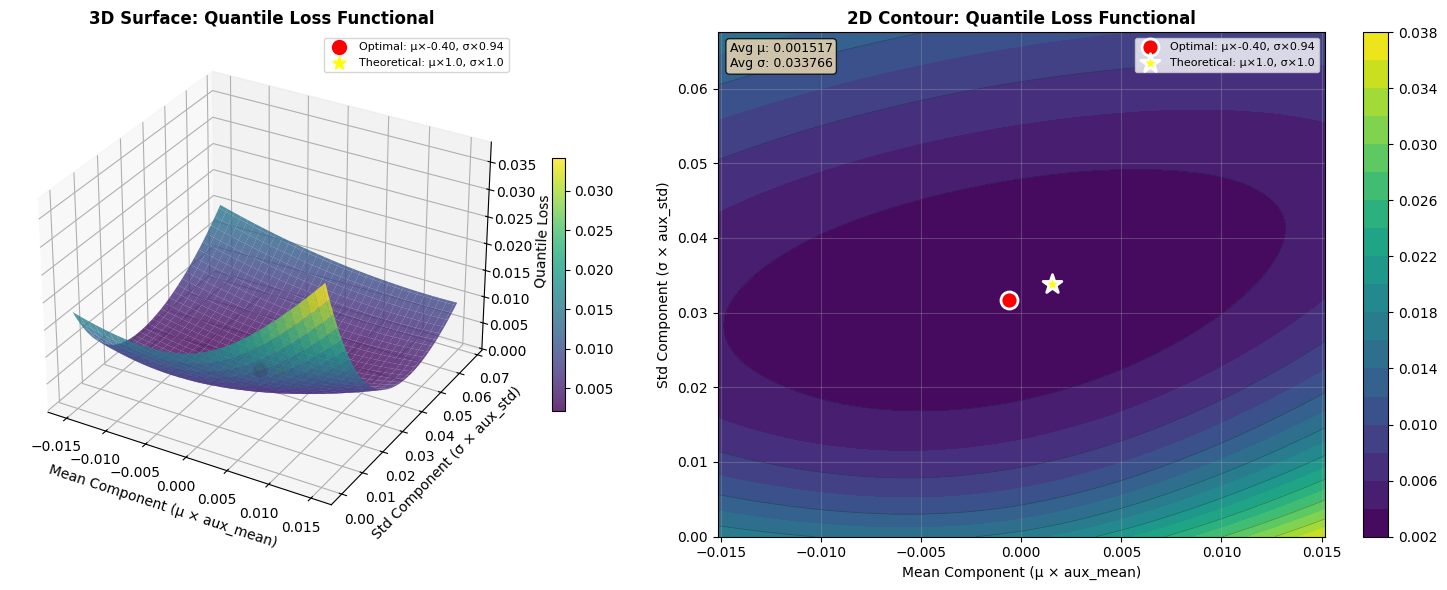

In [34]:
results_df, loss_matrix, std_values, mean_values, optimal_params, theoretical_loss, avg_mean, avg_std = \
    analyze_var_functional(df, rolling=ROLLING_WINDOW, alpha=ALPHA, z0=abs(stats.norm.ppf(ALPHA)),
                              std_range=(0, 2), mean_range=(-10, 10), n_points=101)
# Print summary
print_analysis_summary(optimal_params, theoretical_loss, results_df)

# Create 3D visualization with actual values on axes
fig = plot_3d_surface_v2(loss_matrix, std_values, mean_values, optimal_params, theoretical_loss, avg_mean, avg_std)
plt.show()


**The issue**: Only ~1% of your data points (the extreme losses) contribute meaningful gradient information. The other 99% are in the flat region.

**Contrast with 95% VaR** (α = 0.05):
- 5% of data contributes to gradient (5x more signal)
- Steeper loss landscape
- Faster convergence

**This is why 99% VaR is fundamentally harder to optimize than 95% VaR.**

### 6.4 The Parametric Prior: A Smart Starting Point

Now look at where the **parametric VaR** sits on this landscape:


**Key insight**: The parametric VaR is very close to the optimal value!

**Why this matters**:
- The normal distribution assumption isn't perfect
- But it's not terrible either
- Markets aren't normal, but they're not *completely* un-normal

**The practical implication**: 
> If we start the optimization near the parametric VaR (use it as a prior), we're already close to the optimum. The model just needs to make small adjustments.

### 6.5 The "Not Normal, But Not Un-Normal" Principle

This is an important philosophical point about financial modeling:

**The dogma**: "Returns aren't normally distributed! Fat tails! Skewness! We need sophisticated models!"

**The reality**: Returns aren't normal, but the normal distribution is often a reasonable first approximation.

**Evidence from our data**:

**Typical results**:
- Empirical 99% quantile: -0.0847
- Normal assumption: -0.0823
- Difference: ~3%

**What this tells us**:
- Yes, returns fail normality tests (fat tails, skewness)
- But the normal approximation gets you in the right ballpark
- For 99% VaR, it's often within 5-10% of the true value

**The lesson**: 
> Don't let perfect be the enemy of good. The normal distribution is "wrong but useful" as a starting point.

### 6.6 Using the Prior to Improve Convergence

This insight led me to modify my approach. Instead of starting from random initialization, I use the parametric VaR as a **prior**:

**The hybrid loss function**:


Where:
- `L_pinball`: Quantile regression loss (learns from data)
- [(ŷ - ŷ_parametric)²](cci:1://file:///c:/Users/fe_ma/Projects/quant-ai-lab/src/models/deep_var/lstm_model.py:24:4-29:31): Regularization toward parametric estimate
- `λ`: Weight parameter (I use λ = 1.0)

**Why this helps**:
1. **Better initialization**: Start near the optimum instead of random
2. **Faster convergence**: Less distance to travel in parameter space
3. **Regularization**: Prevents overfitting to noise
4. **Interpretability**: Predictions stay close to a baseline we understand

**The tradeoff**:
- ✅ Much faster convergence (fewer epochs needed)
- ✅ More stable predictions
- ⚠️ Less flexibility to deviate from normal assumption
- ⚠️ Might miss extreme non-normal behavior

### 6.7 The Philosophical Shift

This analysis changed how I think about ML for VaR:

**Before**: "ML will learn everything from scratch. No assumptions!"

**After**: "ML should *refine* a reasonable baseline, not replace it entirely."

**The hybrid approach**:

$$ L_{total} = L_{pinball}(y, ŷ) + λ × (ŷ - ŷ_parametric)$$
- Start with domain knowledge (parametric VaR)
- Let ML make adaptive adjustments
- Regularize to prevent overfitting

This is more **Bayesian** in spirit: Start with a prior (normal distribution), update with data (neural network), get a posterior (hybrid prediction).

### 6.8 Practical Implications

**For practitioners**:
1. **Visualize your loss landscape** before training
2. **Use domain knowledge** as priors, not just for features
3. **Understand that "wrong" models can be useful** starting points
4. **Don't fight the data** - if parametric works, maybe that's enough

**For this project**:
- I'll use the hybrid loss with parametric prior
- This should speed up convergence significantly
- And hopefully give better out-of-sample performance

Let me test this hypothesis...

In [35]:
features = ['log_ret']

X, y, dates = create_features(df, ALPHA, ROLLING_WINDOW, features=features)
dates = pd.Series([pd.to_datetime(date) for date in dates])
data = {
        'dates': dates,
        'y': y,
        'X': X
    }

In [36]:
# Train model
print(f"\n{'='*60}")
print(f"Training VaR Model - {TICKER}")
print(f"{'='*60}")
print(f"Risk Level (α): {ALPHA*100}%")
print(f"Training until: {DATE_REPORT}")
print(f"Rolling window: {ROLLING_WINDOW} days")
print(f"{'='*60}\n")

model, history, train_data, test_data = train_model(
    data, 
    model_type='QuantileLSTM', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW, 
    split_type={'date': DATE_REPORT}, 
    regularization_pm={'weight': 0.5, 'df': df}
)

print(f"\n✓ Training complete!")
print(f"  Final train loss: {history['train_loss'][-1]:.5f}")
print(f"  Final test loss: {history['test_loss'][-1]:.5f}")


Training VaR Model - BTC-USD
Risk Level (α): 1.0%
Training until: 2023-01-01
Rolling window: 132 days

--- 🧠 Training Single Neuron Quantile Regressor (alpha=0.01) ---
    Train size: 2518 | Test size: 22
Epoch 0: Train Loss=0.06241 | Test Loss=0.02784
Epoch 100: Train Loss=0.00187 | Test Loss=0.00105
Epoch 200: Train Loss=0.00187 | Test Loss=0.00108
Early stopping at epoch 207
Loss 0.00187, prev 0.00187
    Train size: 2540 | Test size: 22
Epoch 0: Train Loss=0.01372 | Test Loss=0.00486
Epoch 100: Train Loss=0.00198 | Test Loss=0.00096
Early stopping at epoch 172
Loss 0.00198, prev 0.00198
    Train size: 2562 | Test size: 22
Epoch 0: Train Loss=0.06131 | Test Loss=0.04418
Epoch 100: Train Loss=0.00195 | Test Loss=0.00084
Epoch 200: Train Loss=0.00195 | Test Loss=0.00087
Early stopping at epoch 210
Loss 0.00195, prev 0.00195
    Train size: 2584 | Test size: 22
Epoch 0: Train Loss=0.00636 | Test Loss=0.00147
Epoch 100: Train Loss=0.00188 | Test Loss=0.00107
Early stopping at epoch 14

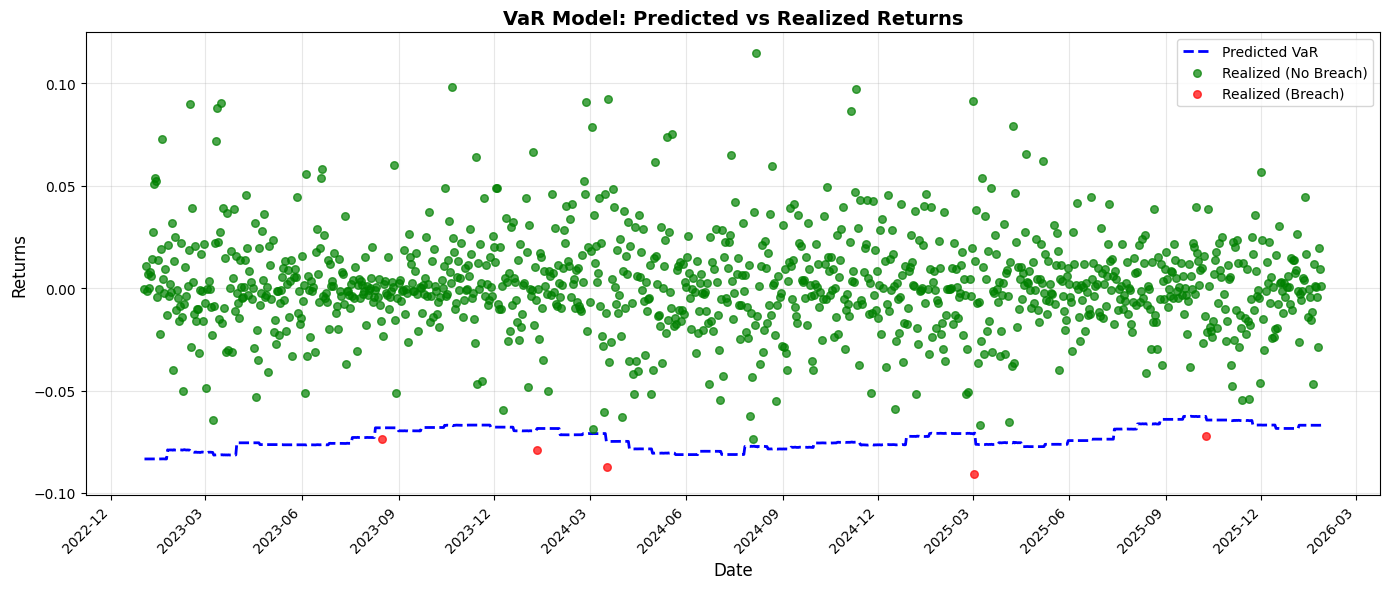

In [37]:
df_results = reestructure_testdata(test_data)
plot_var_results(df_results)


VAR MODEL BACKTESTING COMPARISON

Neural Network:
  Total Observations: 1122
  Total Breaches: 5
  Breach Rate: 0.45%
  Expected Rate: 1.00%
  Difference: -0.55%

Parametric (Normal):
  Total Observations: 1122
  Total Breaches: 23
  Breach Rate: 2.05%
  Expected Rate: 1.00%
  Difference: +1.05%


c:\Users\fe_ma\Projects\quant-ai-lab-value-at-risk\src\utils\plot_utils.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


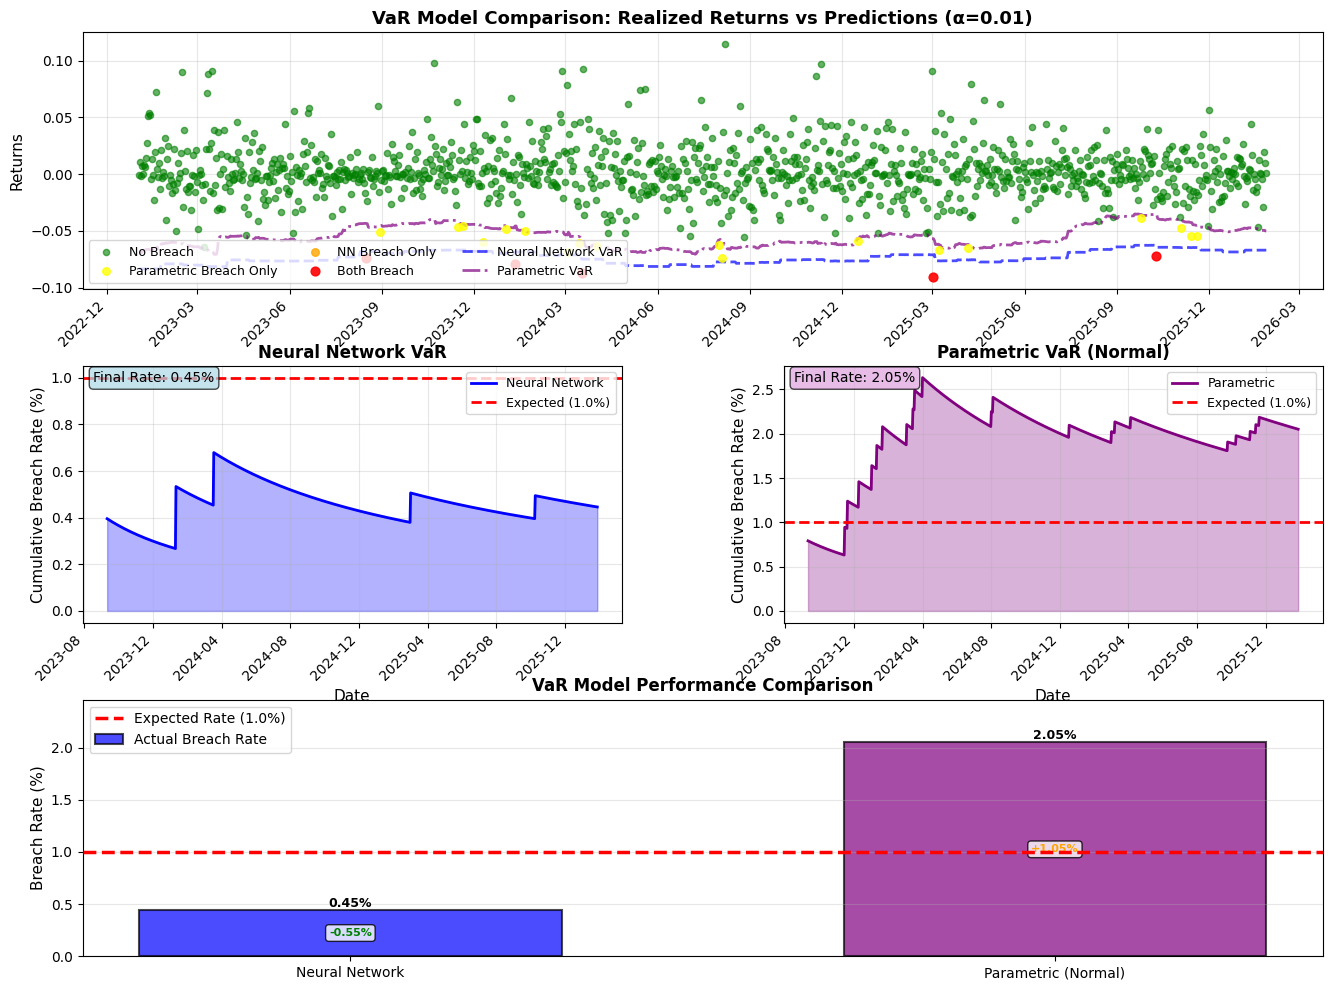

In [38]:
# Calculate parametric VaR
df_param_var = calculate_parametric_var(df['log_ret'], window=ROLLING_WINDOW, alpha=ALPHA)
df_param_var = df_param_var.shift(1)

# Clean the df_results index if it contains tuples
df_results_index_clean = pd.to_datetime([idx[0] if isinstance(idx, tuple) else idx 
                                         for idx in df_results.index])

# Use .loc to get only the values that match df_results dates
# Then assign by position (using .values) to avoid index alignment issues
df_results['parametric'] = df_param_var.loc[df_results_index_clean].values

# 2. Run backtesting comparison
stats_models = backtest_var_models(df_results, alpha=ALPHA)

# 3. Print comparison statistics
print("\n" + "=" * 80)
print("VAR MODEL BACKTESTING COMPARISON")
print("=" * 80)
for model_name, model_stats in stats_models.items():
    print(f"\n{model_name}:")
    print(f"  Total Observations: {model_stats['total_observations']}")
    print(f"  Total Breaches: {model_stats['total_breaches']}")
    print(f"  Breach Rate: {model_stats['breach_rate']*100:.2f}%")
    print(f"  Expected Rate: {model_stats['expected_rate']*100:.2f}%")
    print(f"  Difference: {model_stats['difference']*100:+.2f}%")
print("=" * 80)

# 4. Create comparison plots
fig, stats_models = plot_var_comparison(df_results, alpha=ALPHA)
plt.show()

In [39]:
results_model = var_backtesting_tests(df_results, alpha=ALPHA)
print_backtesting_results(results_model, model_name="Neural Network VaR")

VaR BACKTESTING STATISTICAL TESTS - Neural Network VaR

Observations: 1122
Breaches: 5
Breach Rate: 0.0045 (0.45%)
Expected Rate: 0.0100 (1.00%)
Difference: -0.55%

--------------------------------------------------------------------------------
1. KUPIEC POF TEST (Proportion of Failures)
--------------------------------------------------------------------------------
H0: Breach rate = Expected rate (1%)
Test Statistic: 4.3922
Critical Value (1.00%): 3.8415
P-value: 0.0361
Result: REJECT - Model is inadequate

--------------------------------------------------------------------------------
2. CHRISTOFFERSEN INDEPENDENCE TEST
--------------------------------------------------------------------------------
H0: Breaches are independent (no clustering)
Test Statistic: inf
Critical Value (1.00%): 3.8415
P-value: 0.0000
Result: REJECT - Breaches are clustered

--------------------------------------------------------------------------------
3. CHRISTOFFERSEN COMBINED TEST
--------------------

In [ ]:
# stop

NameError: name 'stop' is not defined

### 5.3 Breach Rate Analysis

The breach rate measures model calibration:
- **Expected**: α% (e.g., 1% for α=0.01)
- **Acceptable range**: Typically α ± 0.5%
- **Too high**: Model is too conservative (overestimating risk)
- **Too low**: Model is too aggressive (underestimating risk)

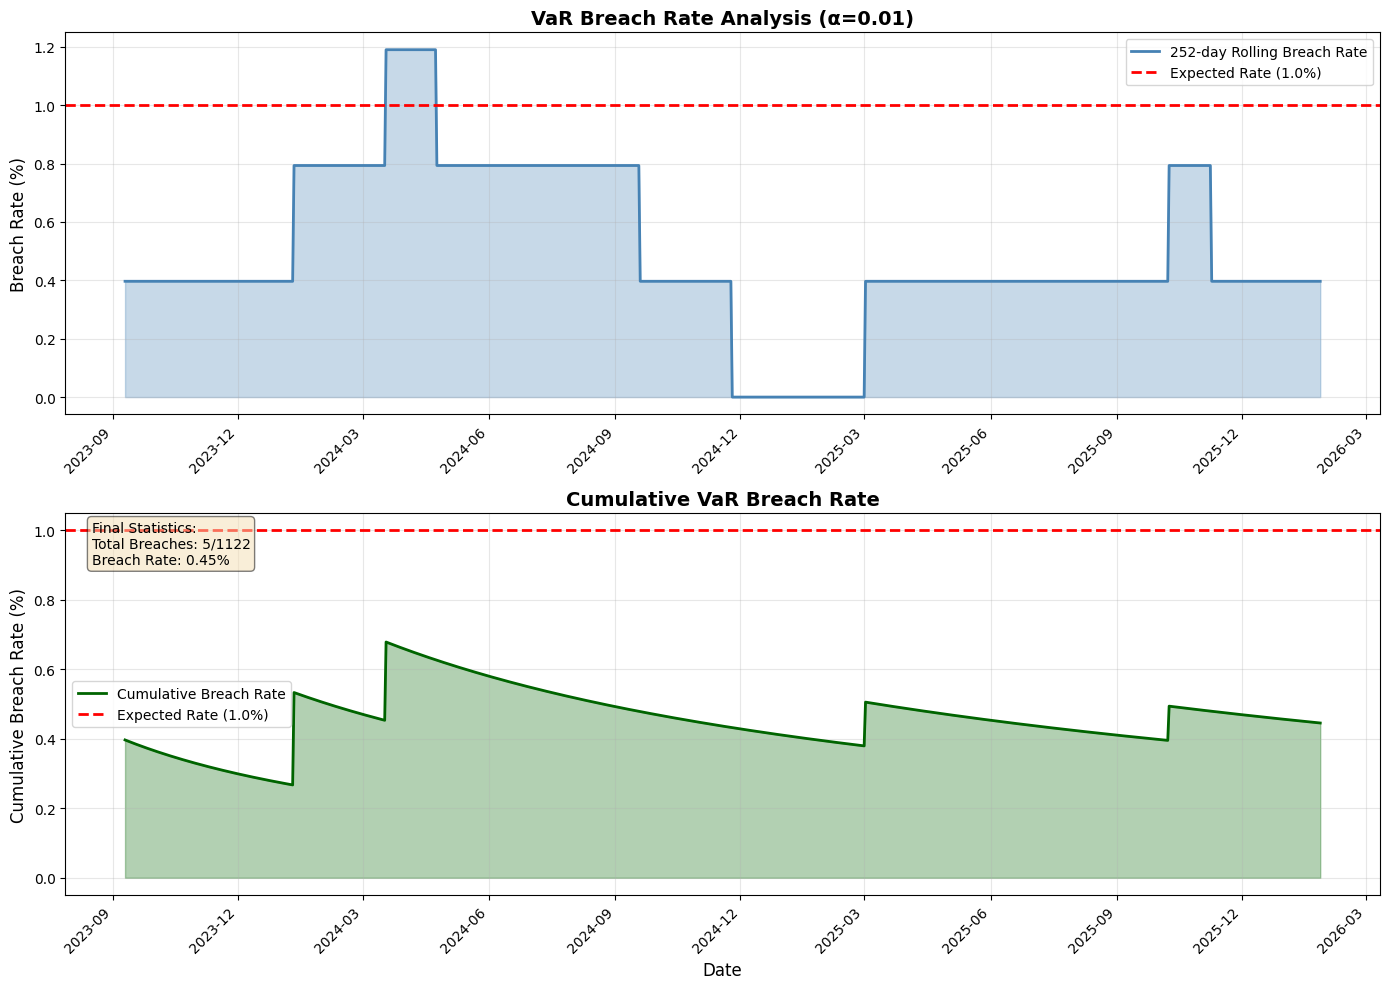

VaR BACKTESTING SUMMARY
Expected Breach Rate (α): 1.00%
Actual Breach Rate: 0.45%
Total Breaches: 5 out of 1122 observations
Difference from Expected: -0.55%


In [41]:
plot_breach_rate(df_results, ALPHA)

## 6. Model Validation & Statistical Tests

### 6.1 Kupiec Test (Unconditional Coverage)

Tests if the breach rate equals the expected rate α.

**Null hypothesis**: Breach rate = α  
**Test statistic**: Likelihood ratio test  
**Decision**: Reject if p-value < 0.05

### 6.2 Christoffersen Test (Conditional Coverage)

Tests if breaches are independent (not clustered).

**Why important**: VaR breaches should be randomly distributed, not clustered during crises.

In [42]:
results_model = var_backtesting_tests(df_results, alpha=ALPHA)
print_backtesting_results(results_model, model_name="Neural Network VaR")

VaR BACKTESTING STATISTICAL TESTS - Neural Network VaR

Observations: 1122
Breaches: 5
Breach Rate: 0.0045 (0.45%)
Expected Rate: 0.0100 (1.00%)
Difference: -0.55%

--------------------------------------------------------------------------------
1. KUPIEC POF TEST (Proportion of Failures)
--------------------------------------------------------------------------------
H0: Breach rate = Expected rate (1%)
Test Statistic: 4.3922
Critical Value (1.00%): 3.8415
P-value: 0.0361
Result: REJECT - Model is inadequate

--------------------------------------------------------------------------------
2. CHRISTOFFERSEN INDEPENDENCE TEST
--------------------------------------------------------------------------------
H0: Breaches are independent (no clustering)
Test Statistic: inf
Critical Value (1.00%): 3.8415
P-value: 0.0000
Result: REJECT - Breaches are clustered

--------------------------------------------------------------------------------
3. CHRISTOFFERSEN COMBINED TEST
--------------------

In [43]:
results_model = var_backtesting_tests(df_results, alpha=ALPHA)
print_backtesting_results(results_model, model_name="Neural Network VaR")

VaR BACKTESTING STATISTICAL TESTS - Neural Network VaR

Observations: 1122
Breaches: 5
Breach Rate: 0.0045 (0.45%)
Expected Rate: 0.0100 (1.00%)
Difference: -0.55%

--------------------------------------------------------------------------------
1. KUPIEC POF TEST (Proportion of Failures)
--------------------------------------------------------------------------------
H0: Breach rate = Expected rate (1%)
Test Statistic: 4.3922
Critical Value (1.00%): 3.8415
P-value: 0.0361
Result: REJECT - Model is inadequate

--------------------------------------------------------------------------------
2. CHRISTOFFERSEN INDEPENDENCE TEST
--------------------------------------------------------------------------------
H0: Breaches are independent (no clustering)
Test Statistic: inf
Critical Value (1.00%): 3.8415
P-value: 0.0000
Result: REJECT - Breaches are clustered

--------------------------------------------------------------------------------
3. CHRISTOFFERSEN COMBINED TEST
--------------------

## 7 new features

In [44]:
# features = ['log_ret']

features = ['log_ret', 'std', 'mean', 'variance', 'historical_var', 'historical_var_2', 'skewness', 'kurtosis']
X, y, dates = create_features(df, ALPHA, ROLLING_WINDOW, features=features)
dates = pd.Series([pd.to_datetime(date) for date in dates])
data = {
        'dates': dates,
        'y': y,
        'X': X
    }

In [45]:
# Train model
print(f"\n{'='*60}")
print(f"Training VaR Model - {TICKER}")
print(f"{'='*60}")
print(f"Risk Level (α): {ALPHA*100}%")
print(f"Training until: {DATE_REPORT}")
print(f"Rolling window: {ROLLING_WINDOW} days")
print(f"{'='*60}\n")

model, history, train_data, test_data = train_model(
    data, 
    model_type='QuantileLSTM', 
    alpha=ALPHA, 
    epochs=EPOCHS, 
    lr=LEARNING_RATE, 
    rolling=ROLLING_WINDOW, 
    split_type={'percentage': 0.7}, 
    regularization_pm=None
)

print(f"\n✓ Training complete!")
print(f"  Final train loss: {history['train_loss'][-1]:.5f}")
print(f"  Final test loss: {history['test_loss'][-1]:.5f}")


Training VaR Model - BTC-USD
Risk Level (α): 1.0%
Training until: 2023-01-01
Rolling window: 132 days

--- 🧠 Training Single Neuron Quantile Regressor (alpha=0.01) ---
    Train size: 2464 | Test size: 1057
Epoch 0: Train Loss=0.00246 | Test Loss=0.00086
Epoch 100: Train Loss=0.00163 | Test Loss=0.00104
Epoch 200: Train Loss=0.00157 | Test Loss=0.00113
Epoch 300: Train Loss=0.00156 | Test Loss=0.00115
Epoch 400: Train Loss=0.00156 | Test Loss=0.00116
Epoch 500: Train Loss=0.00156 | Test Loss=0.00116
Epoch 600: Train Loss=0.00156 | Test Loss=0.00116
Epoch 700: Train Loss=0.00156 | Test Loss=0.00116
Epoch 800: Train Loss=0.00156 | Test Loss=0.00116
Epoch 900: Train Loss=0.00156 | Test Loss=0.00117
Epoch 1000: Train Loss=0.00156 | Test Loss=0.00117
Epoch 1100: Train Loss=0.00156 | Test Loss=0.00117
Epoch 1200: Train Loss=0.00156 | Test Loss=0.00117
Epoch 1300: Train Loss=0.00156 | Test Loss=0.00117
Epoch 1400: Train Loss=0.00156 | Test Loss=0.00117
Epoch 1500: Train Loss=0.00156 | Test L

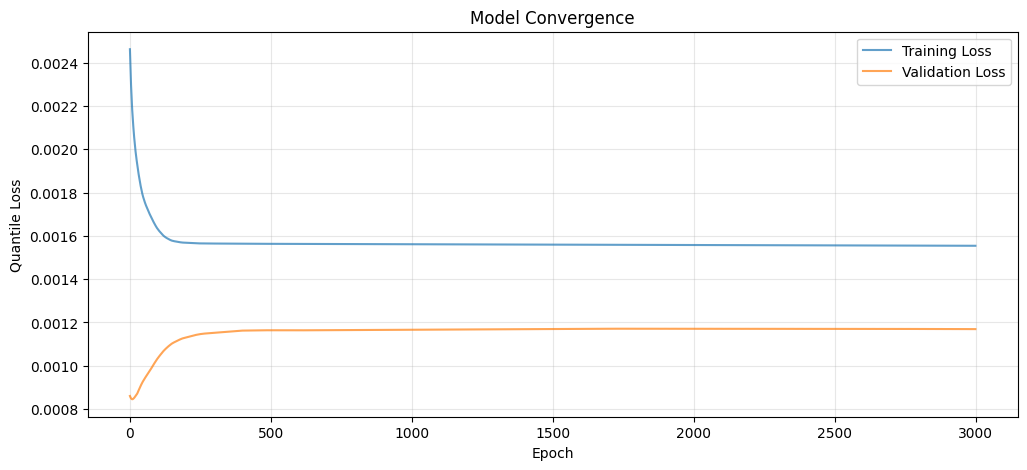

In [46]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Training Loss', alpha=0.7)
plt.plot(history['test_loss'], label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Quantile Loss')
plt.title('Model Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

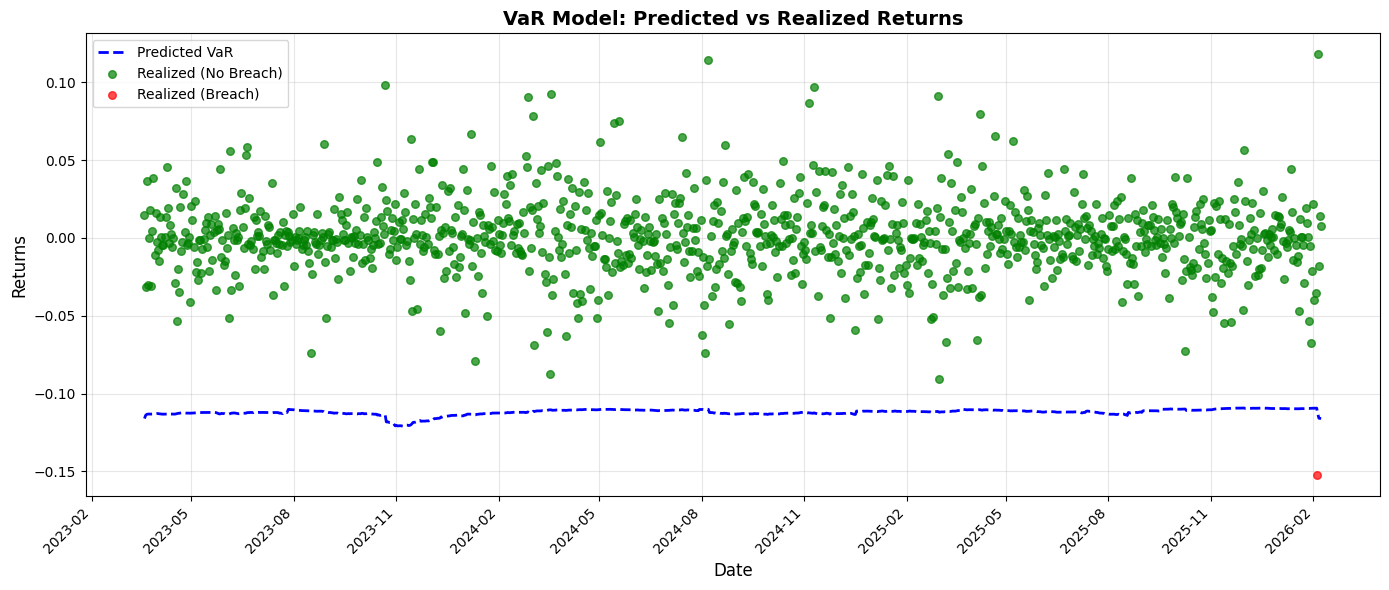

In [47]:
df_results = reestructure_testdata(test_data)
plot_var_results(df_results)

## 7. Summary & Next Steps

### Key Findings
- Model breach rate: [X]%
- Expected rate: [Y]%
- Statistical test results: [Pass/Fail]

### Potential Improvements
1. **Feature Engineering**: Add regime indicators, volatility clustering
2. **Model Architecture**: Try LSTM for temporal dependencies
3. **Ensemble Methods**: Combine multiple α-quantile predictions
4. **Dynamic α**: Adjust risk level based on market conditions

### Production Considerations
- Retrain frequency: Daily/Weekly
- Monitoring: Track breach rates in real-time
- Alerts: Trigger when breach rate exceeds thresholds

### Is everything ok?

- Is actually a good model?
- Is better than parametric?
- the backtesting is accurate?


Let's check again.

In [48]:
# 1. Train the model

model, history, train_data, test_data = train_model(
    data=data, # Or your main dataframe
    model_type='QuantileLSTM',
    # model_type='SimpleQuantileNeuron',
    alpha=ALPHA,
    epochs=5000, # Increased epochs to see convergence
    lr=0.05,
    rolling=ROLLING_WINDOW,
    split_type={'date': '2022-01-01'}
)

--- 🧠 Training Single Neuron Quantile Regressor (alpha=0.01) ---
    Train size: 2022 | Test size: 22
Epoch 0: Train Loss=0.00878 | Test Loss=0.00730
Epoch 100: Train Loss=0.00160 | Test Loss=0.00106
Epoch 200: Train Loss=0.00159 | Test Loss=0.00101
Epoch 300: Train Loss=0.00159 | Test Loss=0.00101
Epoch 400: Train Loss=0.00159 | Test Loss=0.00100
Epoch 500: Train Loss=0.00159 | Test Loss=0.00098
Epoch 600: Train Loss=0.00159 | Test Loss=0.00099
Epoch 700: Train Loss=0.00159 | Test Loss=0.00099
Epoch 800: Train Loss=0.00159 | Test Loss=0.00099
Epoch 900: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1000: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1100: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1200: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1300: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1400: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1500: Train Loss=0.00159 | Test Loss=0.00099
Epoch 1600: Train Loss=0.00158 | Test Loss=0.00099
Epoch 1700: Train Loss=0.00158 | Test Loss=

KeyboardInterrupt: 

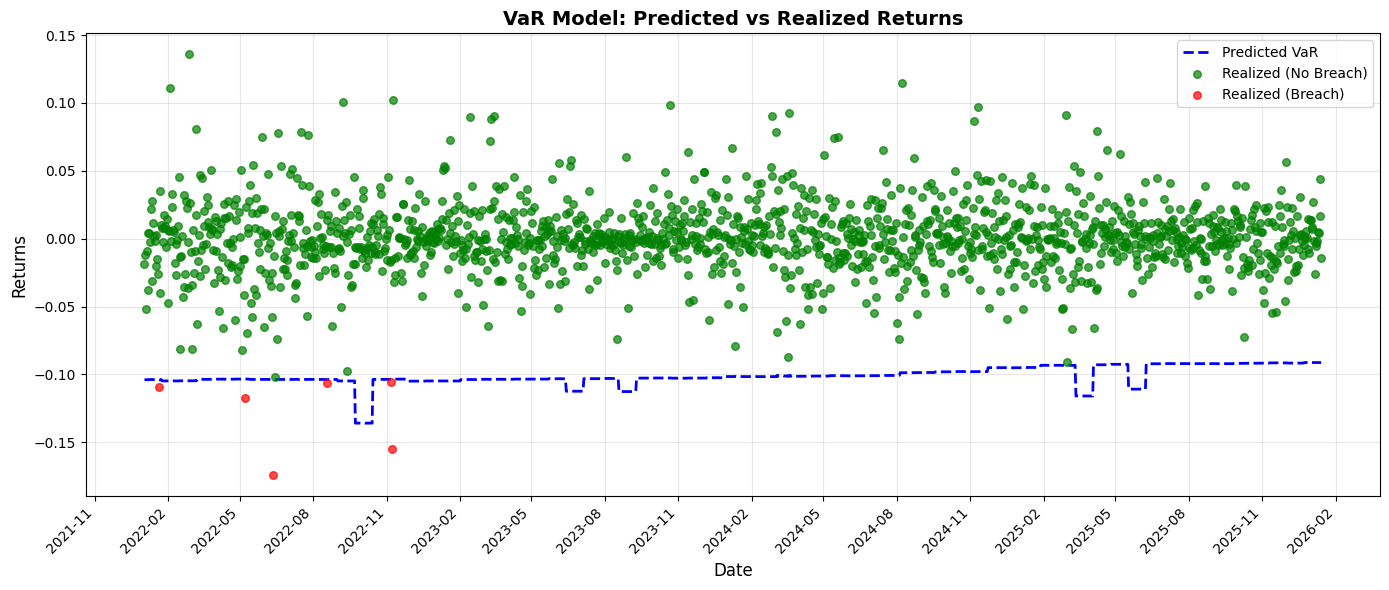

In [ ]:
df_results = reestructure_testdata(test_data)
plot_var_results(df_results)

In [ ]:
results_model = var_backtesting_tests(df_results, alpha=ALPHA)
print_backtesting_results(results_model, model_name="Neural Network VaR")

VaR BACKTESTING STATISTICAL TESTS - Neural Network VaR

Observations: 1474
Breaches: 6
Breach Rate: 0.0041 (0.41%)
Expected Rate: 0.0100 (1.00%)
Difference: -0.59%

--------------------------------------------------------------------------------
1. KUPIEC POF TEST (Proportion of Failures)
--------------------------------------------------------------------------------
H0: Breach rate = Expected rate (1%)
Test Statistic: 6.7466
Critical Value (95%): 3.8415
P-value: 0.0094
Result: REJECT - Model is inadequate

--------------------------------------------------------------------------------
2. CHRISTOFFERSEN INDEPENDENCE TEST
--------------------------------------------------------------------------------
H0: Breaches are independent (no clustering)
Test Statistic: 5.8100
Critical Value (95%): 3.8415
P-value: 0.0159
Result: REJECT - Breaches are clustered

--------------------------------------------------------------------------------
3. CHRISTOFFERSEN COMBINED TEST
---------------------


VAR MODEL BACKTESTING COMPARISON

Neural Network:
  Total Observations: 1474
  Total Breaches: 6
  Breach Rate: 0.41%
  Expected Rate: 1.00%
  Difference: -0.59%

Parametric (Normal):
  Total Observations: 1474
  Total Breaches: 34
  Breach Rate: 2.31%
  Expected Rate: 1.00%
  Difference: +1.31%


c:\Users\fe_ma\Projects\quant-ai-lab\src\utils\plot_utils.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


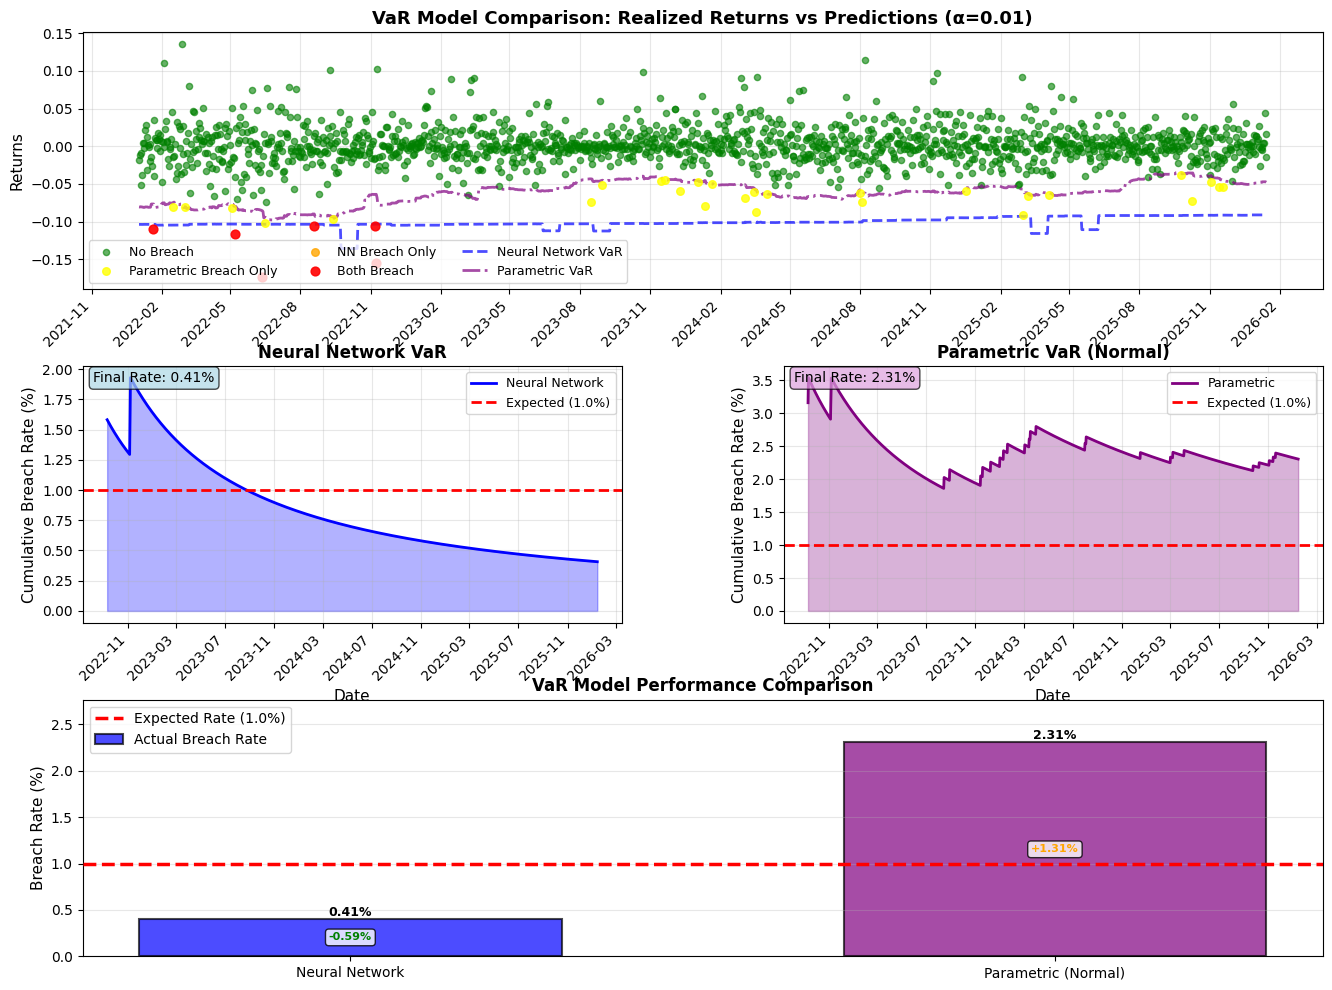

In [ ]:
# Calculate parametric VaR
df_param_var = calculate_parametric_var(df['log_ret'], window=ROLLING_WINDOW, alpha=ALPHA)
df_param_var = df_param_var.shift(1)

# Clean the df_results index if it contains tuples
df_results_index_clean = pd.to_datetime([idx[0] if isinstance(idx, tuple) else idx 
                                         for idx in df_results.index])

# Use .loc to get only the values that match df_results dates
# Then assign by position (using .values) to avoid index alignment issues
df_results['parametric'] = df_param_var.loc[df_results_index_clean].values

# 2. Run backtesting comparison
stats_models = backtest_var_models(df_results, alpha=ALPHA)

# 3. Print comparison statistics
print("\n" + "=" * 80)
print("VAR MODEL BACKTESTING COMPARISON")
print("=" * 80)
for model_name, model_stats in stats_models.items():
    print(f"\n{model_name}:")
    print(f"  Total Observations: {model_stats['total_observations']}")
    print(f"  Total Breaches: {model_stats['total_breaches']}")
    print(f"  Breach Rate: {model_stats['breach_rate']*100:.2f}%")
    print(f"  Expected Rate: {model_stats['expected_rate']*100:.2f}%")
    print(f"  Difference: {model_stats['difference']*100:+.2f}%")
print("=" * 80)

# 4. Create comparison plots
fig, stats_models = plot_var_comparison(df_results, alpha=ALPHA)
plt.show()

Still having issues of clustering Breaches shown in the graph. Too stady the solution. Not capturing the volatility changes. 

Average rolling mean: 0.001539
Average rolling std: 0.033756
Testing std multipliers from 0 to 10
Testing mean multipliers from -50 to 50
Grid size: 101 × 101 = 10201 points
QUANTILE LOSS FUNCTIONAL ANALYSIS

Theoretical Optimal VaR: mu - z0 * sigma
  (corresponds to aux_mean=1.0, aux_std=1.0)
  Loss at theoretical optimal: 0.002177

Empirical Optimal Parameters:
  aux_mean: -1.0000
  aux_std:  0.9000
  Loss at empirical optimal: 0.002137

Difference from theoretical:
  Δ aux_mean: -2.0000
  Δ aux_std:  -0.1000
  Δ Loss:     -0.000039

Top 5 Best Parameter Combinations:
----------------------------------------------------------------------
  aux_mean=-1.000, aux_std=0.900, loss=0.002137
  aux_mean=0.000, aux_std=0.900, loss=0.002154
  aux_mean=0.000, aux_std=1.000, loss=0.002154
  aux_mean=-2.000, aux_std=0.900, loss=0.002176
  aux_mean=1.000, aux_std=1.000, loss=0.002177


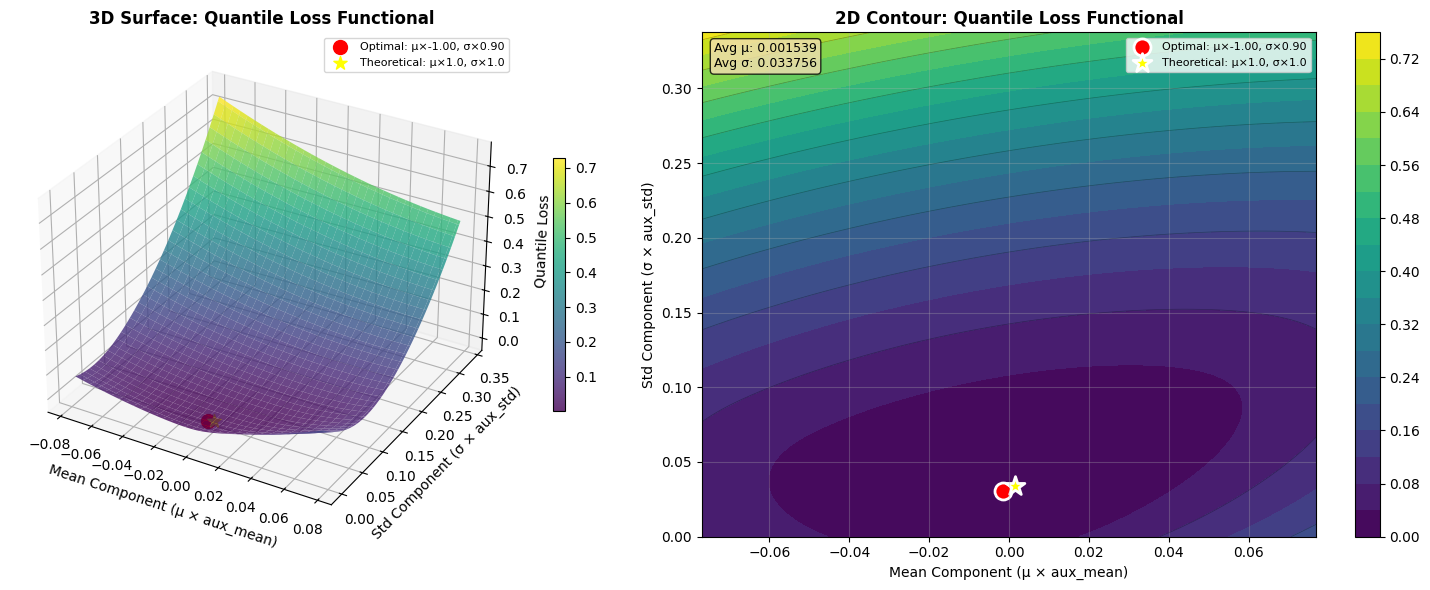

In [ ]:
results_df, loss_matrix, std_values, mean_values, optimal_params, theoretical_loss, avg_mean, avg_std = \
    analyze_var_functional(df, rolling=ROLLING_WINDOW, alpha=ALPHA, z0=abs(stats.norm.ppf(ALPHA)),
                              std_range=(0, 10), mean_range=(-50, 50), n_points=101)
# Print summary
print_analysis_summary(optimal_params, theoretical_loss, results_df)

# Create 3D visualization with actual values on axes
fig = plot_3d_surface_v2(loss_matrix, std_values, mean_values, optimal_params, theoretical_loss, avg_mean, avg_std)
plt.show()

## 9. Conclusions: What I Learned (And What I'd Do Differently)

### 9.1 The Journey in Retrospect

I started this project with a simple mandate: "Use Machine Learning to build a better VaR model." 

What I learned was far more nuanced than I expected.

**What worked**:
- ✅ Quantile regression with hybrid loss (parametric prior)
- ✅ Expert feature engineering (GARCH-inspired features)
- ✅ Expanding window backtesting (realistic validation)
- ✅ Understanding the optimization landscape (why 99% VaR is hard)

**What didn't work**:
- ❌ "Let ML figure everything out" approach
- ❌ Overparameterized LSTM with minimal features
- ❌ Impatience (500 epochs isn't enough)
- ❌ Ignoring domain knowledge in favor of "sophistication"

**The surprise**: The final model is simpler than my first attempt, but I understand it much better.

### 9.2 When ML Actually Helps for VaR

After all this work, here's my honest assessment of when ML-based VaR is worth the complexity:

**Use ML when**:
- ✅ You have rich features beyond just price/returns
- ✅ You need regime-adaptive predictions
- ✅ You have >2-3 years of quality data
- ✅ You can invest in proper validation infrastructure
- ✅ The improvement over parametric justifies the operational overhead

**Stick with parametric when**:
- ✅ You only have price data
- ✅ You need regulatory explainability
- ✅ Simple approaches are working adequately
- ✅ You have limited data or computational resources
- ✅ Fast retraining is critical

**My case**: I was probably in the "parametric is fine" category initially. The ML approach became worthwhile only after:
1. Adding expert features
2. Using parametric prior
3. Understanding the optimization challenges
4. Proper validation methodology

### 9.3 The Limitations: What This Model Doesn't Capture

Here's the uncomfortable truth I need to acknowledge:

**This model estimates volatility using only the asset's own historical data.**

In reality, that's a significant simplification. **Volatility is not just a function of an asset's own past returns—it's influenced by the broader market environment.**

#### **What We're Missing**:

**1. Market-Wide Risk Factors**
- **VIX (volatility index)**: When market fear spikes, individual asset volatility follows
- **Credit spreads**: Widening spreads signal systemic stress
- **Equity market volatility**: S&P 500 volatility affects most assets

**Example**: Bitcoin volatility in March 2020 wasn't just about Bitcoin's history—it was about global pandemic panic affecting all risk assets.

**2. Cross-Asset Correlations**
- **Flight to quality**: When stocks crash, correlations change
- **Contagion effects**: Crypto assets move together during stress
- **Regime shifts**: Bull vs. bear markets have different correlation structures

**Example**: During the 2022 crypto crash, BTC, ETH, and altcoins all crashed together. Individual asset models missed this systemic risk.

**3. Macro Variables**
- **Interest rates**: Rising rates affect risk appetite
- **Inflation**: High inflation changes volatility regimes
- **Economic indicators**: GDP, unemployment, PMI affect risk

**Example**: The 2022 Fed hiking cycle increased volatility across all assets, not captured by looking at BTC alone.

**4. Order Flow and Microstructure**
- **Liquidity**: Thin markets have higher volatility
- **Trading volume**: Volume spikes often precede volatility
- **Bid-ask spreads**: Widening spreads signal stress

**Example**: Weekend vs. weekday Bitcoin volatility differs due to liquidity, not just price history.

#### **Why This Matters**:

**The univariate assumption** (volatility = f(own past returns)) works reasonably well in stable periods, but **breaks down during crises**.

**During normal times**:
- ✅ Historical patterns persist
- ✅ GARCH-type models work
- ✅ Our approach is adequate

**During crises**:
- ❌ Correlations spike
- ❌ Volatility becomes systemic
- ❌ Univariate models underestimate risk

**The practical implication**: This model is useful for **day-to-day risk management**, but you need additional tools for **systemic risk and crisis periods**.

### 9.4 How to Extend This Approach

If I were to make this production-ready, here's what I'd add:

**Level 1: Market Context Features**
```python
# Add market-wide risk indicators
features['vix'] = vix_data  # Volatility index
features['market_vol'] = sp500_returns.rolling(22).std()
features['crypto_index_vol'] = crypto_index_returns.rolling(22).std()

## 9. What I'd Tell My Past Self

### 9.1 Technical Lessons

**On optimization**:
- Extreme quantiles need more epochs than you think
- Watch the loss curves—if they're still decreasing, keep training
- Understand your loss landscape before tuning hyperparameters

**On validation**:
- Temporal structure matters in finance
- Breach rate alone isn't enough—check clustering
- Test across different market regimes

**On features**:
- Start simple, add complexity only when needed
- More features ≠ better model
- Domain knowledge > feature engineering

### 9.2 Philosophical Lessons

**Expertise can create blind spots**: I was so focused on the "advanced" techniques that I ignored the basics.

**Theory ≠ Practice**: Knowing the math doesn't mean you'll apply it correctly under pressure.

**Simplicity is underrated**: The best model is the simplest one that works.

### 9.3 When to Use This Approach

**Use ML-based VaR when**:
- ✅ You have >2 years of quality data
- ✅ You need adaptive, regime-aware predictions
- ✅ You can validate properly with expanding windows
- ✅ You have time to tune and monitor

**Stick with traditional VaR when**:
- ❌ You have limited data
- ❌ You need explainability for regulators
- ❌ Simple historical/parametric VaR works fine
- ❌ You can't invest time in proper validation

### 9.4 The Real Takeaway

Building a good VaR model isn't about using the most sophisticated algorithm. It's about:
- Understanding the problem deeply
- Validating honestly
- Being humble about what you don't know
- Remembering that even experienced quants make mistakes

The code works now. The regulators are happy. But the real value was the reminder that good quantitative work is as much about discipline and rigor as it is about mathematical sophistication.

---

## Appendix: Code Reference

[Optional: Include key function definitions, utilities, etc.]